# Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = r"/content/drive/MyDrive/Kakao/model"
os.chdir(path)

In [ ]:
!pip install -q -U "neptune[tensorflow-keras]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
#import neptune
#from neptune.integrations.tensorflow_keras import NeptuneCallback

In [ ]:
import pathlib
import numpy as np
import numpy
import os
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import sklearn.metrics as metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.applications import EfficientNetB3, VGG16
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Import Helper Functions

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
def predict_class_label_number(dataset, model):
  rev_label_names = {l: i for i, l in enumerate(class_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=128)
  ]

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g', cmap='Blues')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

# Load Data

In [ ]:
train_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train")
test_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/test")
val_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation")

# Define the class names
# There is a .DS_Store file, so we need to exclude it in our classes
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(len(class_names))
print(class_names)

list_train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
list_test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'))
list_val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))

for f in list_train_ds.take(5):
  print(f.numpy())

3
['partly brown' 'partly purple' 'well fermented']
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly brown/CROP3_37_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly brown/CROP41_51_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented/CROP34_37_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple/CROP14_7_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple/CROP12_68_otsu.jpg'


In [ ]:
# cek jumlah gambar data train
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# cek jumlah gambar data validation
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# cek jumlah gambar data test
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly brown'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/partly brown'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/well fermented'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/partly purple'.
There are 3 dir

In [ ]:
img_size= 224
input_shape = (img_size, img_size, 3)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    return img
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, batch_size, shuffle=True):
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    # Shuffle the data if True or False
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    # Batch all dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
# Data augmentation
data_augmentation = Sequential([
    preprocessing.RandomCrop(height=img_size, width=img_size),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomContrast((0.2, 0.2)),
    preprocessing.RandomZoom((-0.2, 0)),
    preprocessing.RandomRotation(0.2)
])

# Run

## **ResNet50**

### ResNet50_1

*   Batch Size: 32
*   Learning rate: 0.001
*   Epoch: 100

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_1 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_1)
# dropout = layers.Dropout(dropout_rate)(pooling)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_1 = Model(inputs=inputs, outputs=outputs)

epochs = 100
# decay_steps = int(round(len(train_data)/batch_size))*epochs
# cosine_decay = CosineDecay(initial_learning_rate=1e-3, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_1.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_ResNet50_1 = model_ResNet50_1.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100
15/15 [==============================] - 257s 2s/step - loss: 0.8115 - accuracy: 0.7375 - val_loss: 58230.6836 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 7s 337ms/step - loss: 0.4419 - accuracy: 0.8542 - val_loss: 142102.7031 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 9s 497ms/step - loss: 0.3556 - accuracy: 0.8646 - val_loss: 13701.2510 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - 8s 448ms/step - loss: 0.1847 - accuracy: 0.9208 - val_loss: 484.8566 - val_accuracy: 0.3333
Epoch 5/100
15/15 [==============================] - 8s 452ms/step - loss: 0.0880 - accuracy: 0.9688 - val_loss: 119.8238 - val_accuracy: 0.3500
Epoch 6/100
15/15 [==============================] - 8s 457ms/step - loss: 0.0787 - accuracy: 0.9667 - val_loss: 37.2527 - val_accuracy: 0.4000
Epoch 7/100
15/15 [==============================] - 8s 453m

In [ ]:
model_ResNet50_1 = tf.keras.models.load_model("/content/drive/MyDrive/Semeseter_7/all_shortcut/Otsu/model_ResNet50_1")
batch_size = 16

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

In [ ]:
# data test
loss, accuracy = model_ResNet50_1.evaluate(train_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

35/35 [==============================] - 6s 54ms/step - loss: 11.3083 - accuracy: 0.2464
Loss : 11.308302879333496
Accuracy : 0.24642856419086456


In [ ]:
# Check out the layers in our model
model_ResNet50_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


channel gambar ada 3 yaitu RGB, dan setelah memasuki layer konvolusi dia akan menjadi feature map. Total feature map Resnet50 ada 2048

https://github.com/IoannisNasios/keras_model_summary

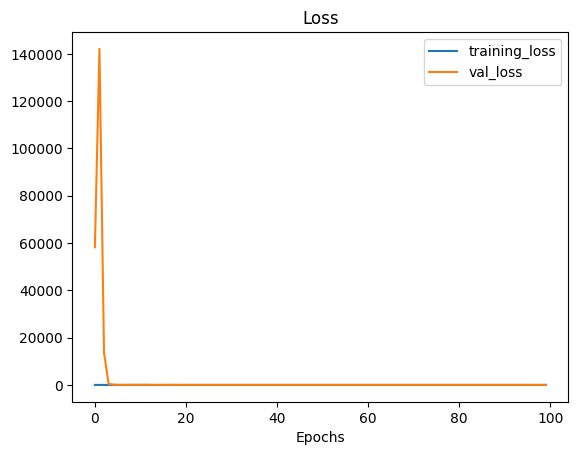

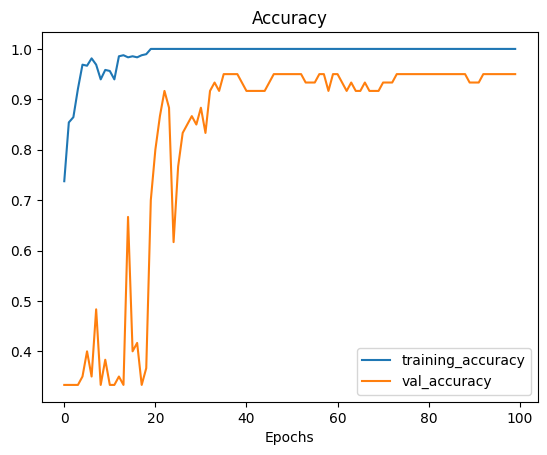

In [ ]:
# Menampilkan grafik pelatihan
plot_loss_curves(history_ResNet50_1)

In [ ]:
# Matriks Konfusi
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_1.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 46ms/step


In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff


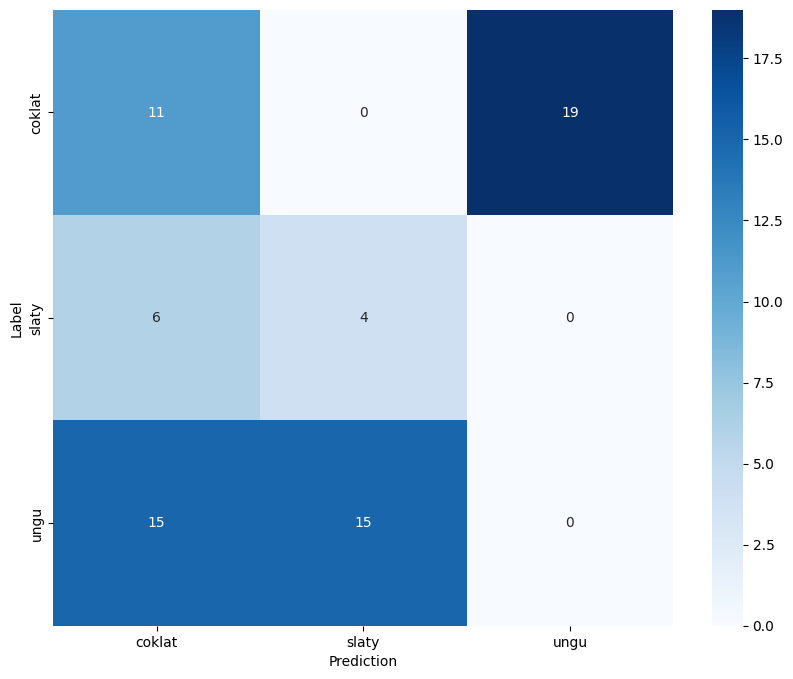

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
# Menampilkan matriks konfusi
z = confusion_mtx[::-1]
x = class_names
y =  x[::-1].copy()
heatmap = go.Heatmap(z=z, x=x, y=y, colorscale='Blues')

annotations = []
for i, row in enumerate(confusion_mtx.numpy().T):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x": x[i],
                "y": x[j],
                "font": {"color": "black", "size" : 120},
                "text": str(value),
                "xref": "x1",
                "yref": "y1",
                "showarrow": False
            }
        )
layout = {
      "title": 'a',
      "xaxis": {"title": "Predictions"},
      "yaxis": {"title": "Labels"},
      "annotations": annotations
  }
fig = go.Figure(data=[heatmap], layout=layout)
fig.update_yaxes(tickangle=-90)
fig.update_layout(
    width=800, height=800,
    font=dict(
      family="Arial", size=18,),
)
# show the figure
fig.show()

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_1.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-19-ac5619af587e>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_1.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.63      0.95      0.76        20
 partly purple       0.94      0.75      0.83        20
well fermented       1.00      0.70      0.82        20

      accuracy                           0.80        60
     macro avg       0.86      0.80      0.81        60
  weighted avg       0.86      0.80      0.81        60



In [ ]:
# save model
model_ResNet50_1.save("model_ResNet50_1")

### ResNet50_2

*   Batch Size: 32
*   Learning rate: 0.005
*   Epoch: 100

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_2 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_2)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_2 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])
history_ResNet50_2 = model_ResNet50_2.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/100
15/15 [==============================] - 56s 876ms/step - loss: 1.0325 - accuracy: 0.6313 - val_loss: 2136735646960582656.0000 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 13s 750ms/step - loss: 0.5948 - accuracy: 0.7625 - val_loss: 1976064523894784.0000 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 12s 763ms/step - loss: 0.4795 - accuracy: 0.8354 - val_loss: 4369671258112.0000 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - 10s 622ms/step - loss: 0.5804 - accuracy: 0.7667 - val_loss: 74487939072.0000 - val_accuracy: 0.3333
Epoch 5/100
15/15 [==============================] - 9s 495ms/step - loss: 0.3997 - accuracy: 0.8458 - val_loss: 162202928.0000 - val_accuracy: 0.3333
Epoch 6/100
15/15 [==============================] - 11s 654ms/step - loss: 0.3678 - accuracy: 0.8521 - val_loss: 5960816.0000 - val_accuracy: 0.3333
Epoch 7/100
15/15 [==============================] - 14s 856ms/step 

In [ ]:
# data test
loss, accuracy = model_ResNet50_2.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 104ms/step - loss: 0.6508 - accuracy: 0.8167
Loss : 0.6508041024208069
Accuracy : 0.8166666626930237


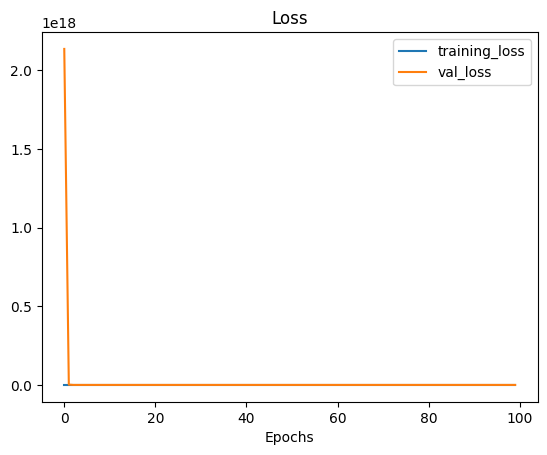

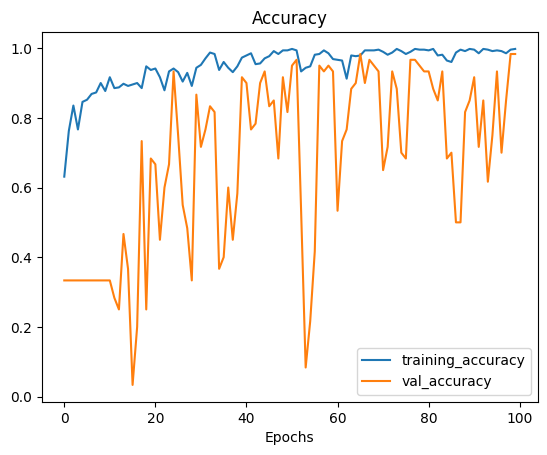

In [ ]:
plot_loss_curves(history_ResNet50_2)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_2.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 859ms/step


1/1 [==============================] - 1s 873ms/step


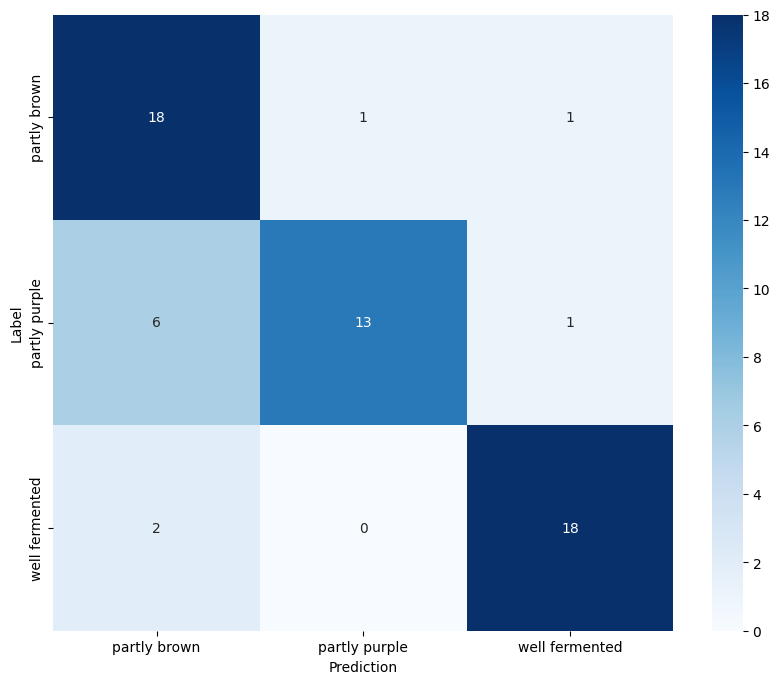

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_2.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-26-33dee2bf5989>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_2.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.68      0.95      0.79        20
 partly purple       1.00      0.65      0.79        20
well fermented       0.89      0.85      0.87        20

      accuracy                           0.82        60
     macro avg       0.86      0.82      0.82        60
  weighted avg       0.86      0.82      0.82        60



In [ ]:
# save model
model_ResNet50_2.save("model_ResNet50_2")

### ResNet50_3

*   Batch Size: 64
*   Learning rate: 0.001
*   Epoch: 100

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_3 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_3)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_3 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_3.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
history_ResNet50_3 = model_ResNet50_3.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/100
8/8 [==============================] - 60s 2s/step - loss: 0.8973 - accuracy: 0.6667 - val_loss: 8809.1377 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 7s 627ms/step - loss: 0.2621 - accuracy: 0.9125 - val_loss: 28843.0840 - val_accuracy: 0.3333
Epoch 3/100
8/8 [==============================] - 9s 964ms/step - loss: 0.4575 - accuracy: 0.8417 - val_loss: 924.5538 - val_accuracy: 0.3333
Epoch 4/100
8/8 [==============================] - 6s 622ms/step - loss: 0.1607 - accuracy: 0.9542 - val_loss: 3792.3538 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 0.1255 - accuracy: 0.9500 - val_loss: 435.4842 - val_accuracy: 0.3333
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 0.0996 - accuracy: 0.9521 - val_loss: 62.6134 - val_accuracy: 0.3333
Epoch 7/100
8/8 [==============================] - 9s 969ms/step - loss: 0.0750 - accuracy: 0.9708 - val_loss: 13.8532 - val_accuracy: 0.5833
Epo

In [ ]:
# data test
loss, accuracy = model_ResNet50_3.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 525ms/step - loss: 0.4959 - accuracy: 0.8333
Loss : 0.4959198236465454
Accuracy : 0.8333333134651184


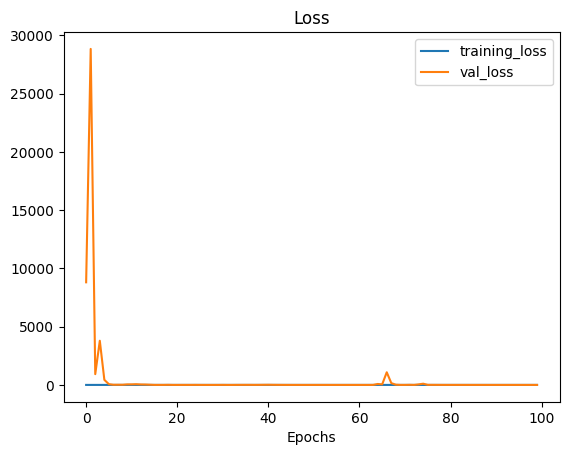

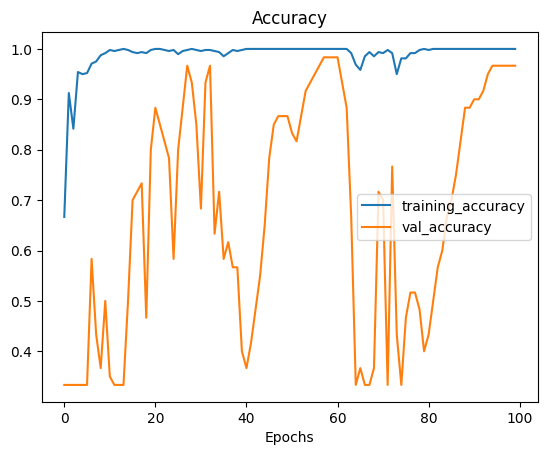

In [ ]:
plot_loss_curves(history_ResNet50_3)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_3.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 3s 119ms/step


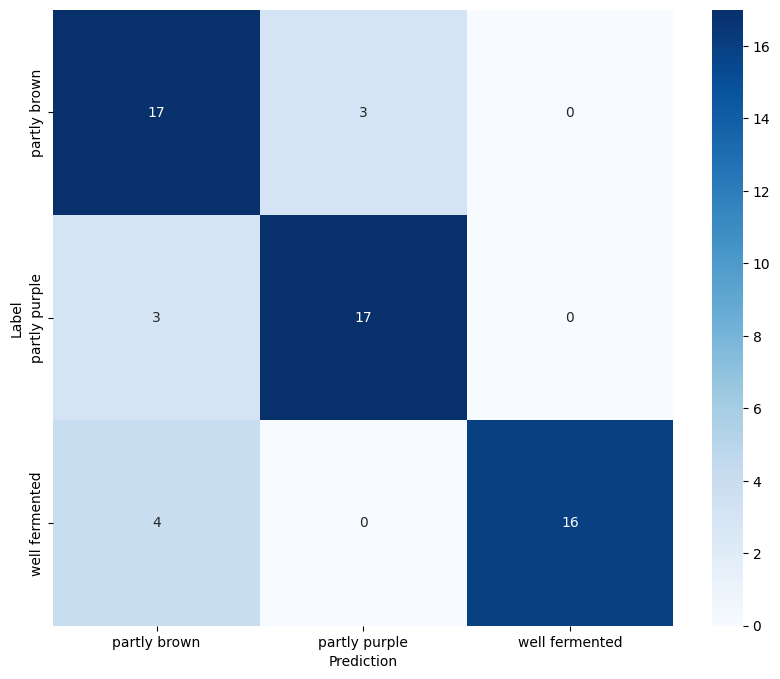

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_3.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-33-0b9299b35fae>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_3.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.64      0.90      0.75        20
 partly purple       0.89      0.80      0.84        20
well fermented       1.00      0.70      0.82        20

      accuracy                           0.80        60
     macro avg       0.84      0.80      0.81        60
  weighted avg       0.84      0.80      0.81        60



In [ ]:
# save model
model_ResNet50_3.save("model_ResNet50_3")

### ResNet50_4

*   Batch Size: 64
*   Learning rate: 0.005
*   Epoch: 100


In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_4 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_4)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_4 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_4.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])
history_ResNet50_4 = model_ResNet50_4.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/100
8/8 [==============================] - 124s 4s/step - loss: 3.1272 - accuracy: 0.4792 - val_loss: 8312997248237568.0000 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 8s 866ms/step - loss: 0.6553 - accuracy: 0.7437 - val_loss: 114403802349568.0000 - val_accuracy: 0.3333
Epoch 3/100
8/8 [==============================] - 8s 874ms/step - loss: 0.4535 - accuracy: 0.8375 - val_loss: 181271314432.0000 - val_accuracy: 0.3333
Epoch 4/100
8/8 [==============================] - 9s 949ms/step - loss: 0.3585 - accuracy: 0.8771 - val_loss: 1014575104.0000 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 9s 956ms/step - loss: 0.2824 - accuracy: 0.8896 - val_loss: 19431308.0000 - val_accuracy: 0.3333
Epoch 6/100
8/8 [==============================] - 8s 858ms/step - loss: 0.3035 - accuracy: 0.8813 - val_loss: 7714759.5000 - val_accuracy: 0.3333
Epoch 7/100
8/8 [===========

In [ ]:
# data test
loss, accuracy = model_ResNet50_4.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 7s 7s/step - loss: 0.8364 - accuracy: 0.8333
Loss : 0.8363621830940247
Accuracy : 0.8333333134651184


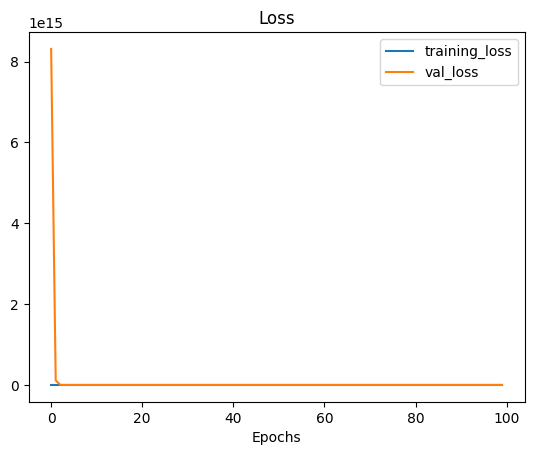

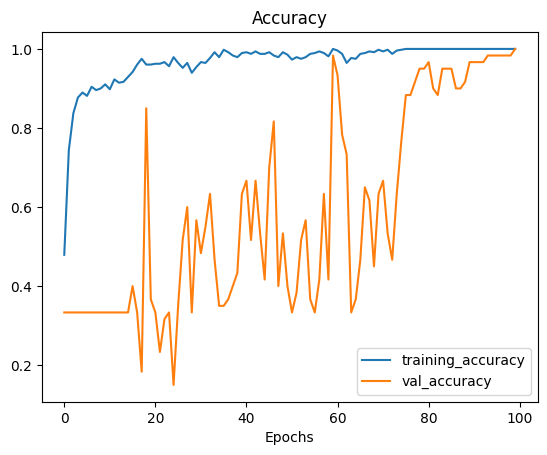

In [ ]:
plot_loss_curves(history_ResNet50_4)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_4.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 2s 1s/step


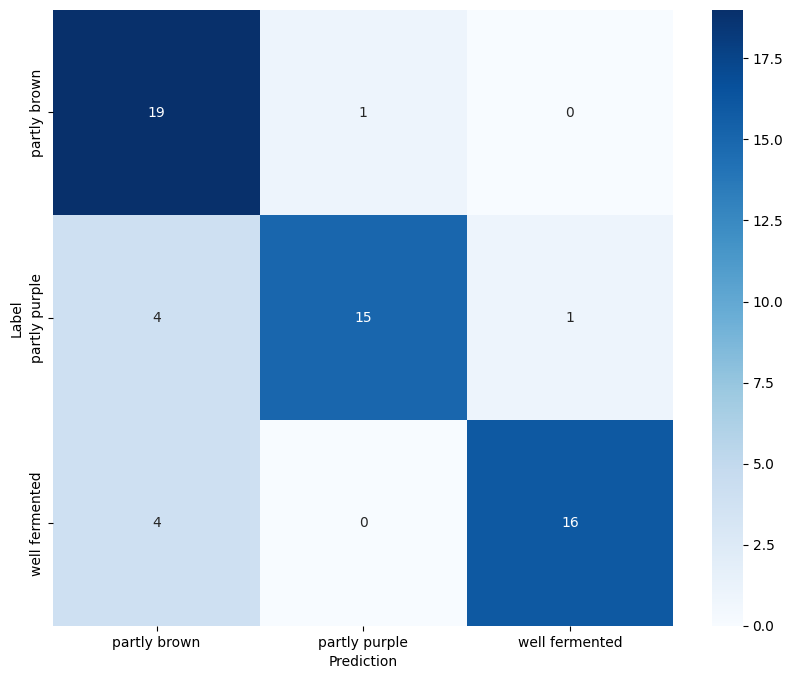

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_4.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-17-b3fd57cfb90d>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_4.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.71      1.00      0.83        20
 partly purple       1.00      0.75      0.86        20
well fermented       0.94      0.80      0.86        20

      accuracy                           0.85        60
     macro avg       0.89      0.85      0.85        60
  weighted avg       0.89      0.85      0.85        60



In [ ]:
# save model
model_ResNet50_4.save("model_ResNet50_4")

### ResNet50_5

*   Batch Size: 32
*   Learning rate: 0.001
*   Epoch: 200

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_5 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_5)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_5 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_5.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
history_ResNet50_5 = model_ResNet50_5.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 62s 1s/step - loss: 1.0337 - accuracy: 0.6521 - val_loss: 8.4397 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 7s 376ms/step - loss: 0.2506 - accuracy: 0.9229 - val_loss: 61.0282 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 7s 357ms/step - loss: 0.2077 - accuracy: 0.9229 - val_loss: 50.5224 - val_accuracy: 0.5000
Epoch 4/200
15/15 [==============================] - 7s 361ms/step - loss: 0.1754 - accuracy: 0.9438 - val_loss: 19.2933 - val_accuracy: 0.4000
Epoch 5/200
15/15 [==============================] - 10s 619ms/step - loss: 0.0970 - accuracy: 0.9688 - val_loss: 5.7562 - val_accuracy: 0.6167
Epoch 6/200
15/15 [==============================] - 8s 366ms/step - loss: 0.0995 - accuracy: 0.9625 - val_loss: 27.2138 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 7s 364ms/step - loss: 0.0788 - accuracy: 0.9750 - val_loss: 26.0359 - val_accuracy: 0.

In [ ]:
# data test
loss, accuracy = model_ResNet50_5.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 118ms/step - loss: 0.8569 - accuracy: 0.8333
Loss : 0.8569477796554565
Accuracy : 0.8333333134651184


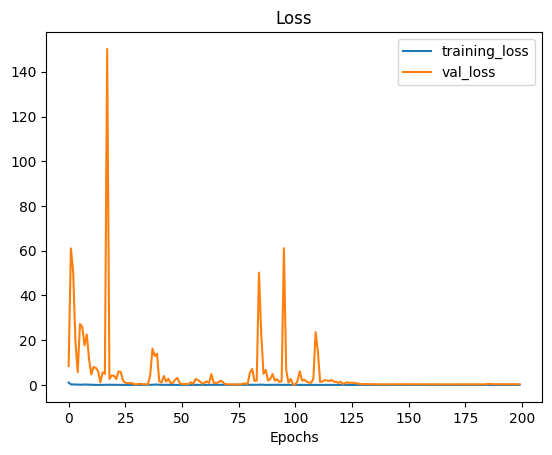

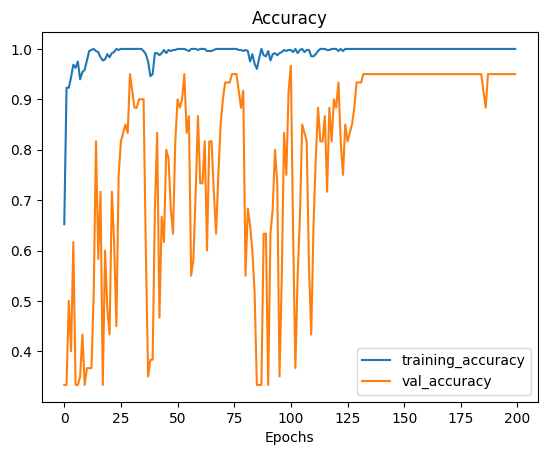

In [ ]:
plot_loss_curves(history_ResNet50_5)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_5.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 852ms/step


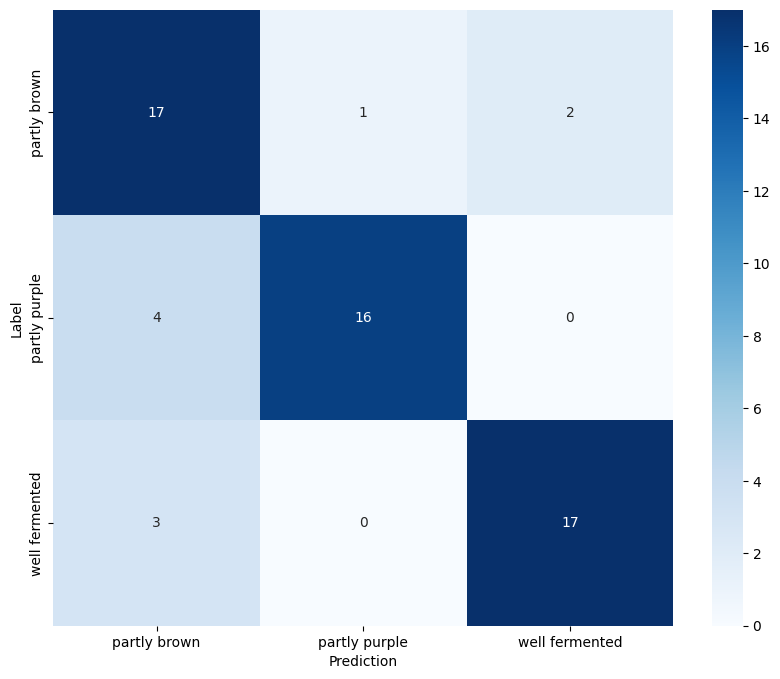

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_5.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-24-1081edece02a>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_5.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.67      0.90      0.77        20
 partly purple       0.94      0.80      0.86        20
well fermented       0.94      0.75      0.83        20

      accuracy                           0.82        60
     macro avg       0.85      0.82      0.82        60
  weighted avg       0.85      0.82      0.82        60



In [ ]:
# save model
model_ResNet50_5.save("model_ResNet50_5")

### ResNet50_6

*   Batch Size: 32
*   Learning rate: 0.005
*   Epoch: 200

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 56s 1s/step - loss: 1.5460 - accuracy: 0.4979 - val_loss: 2122919837696.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 13s 765ms/step - loss: 0.8867 - accuracy: 0.5375 - val_loss: 1751508320256.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 12s 728ms/step - loss: 0.7431 - accuracy: 0.6604 - val_loss: 2597566208.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 12s 765ms/step - loss: 0.5805 - accuracy: 0.7625 - val_loss: 135850992.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 11s 667ms/step - loss: 0.5090 - accuracy: 0.8000 - val_loss: 614664.1250 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 10s 569ms/step - loss: 0.3860 - accuracy: 0.8292 - val_loss: 13076.1660 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 7s 346ms/step - loss: 0.4023 - accur

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 107ms/step - loss: 1.1310 - accuracy: 0.8500
Loss : 1.1309683322906494
Accuracy : 0.8500000238418579


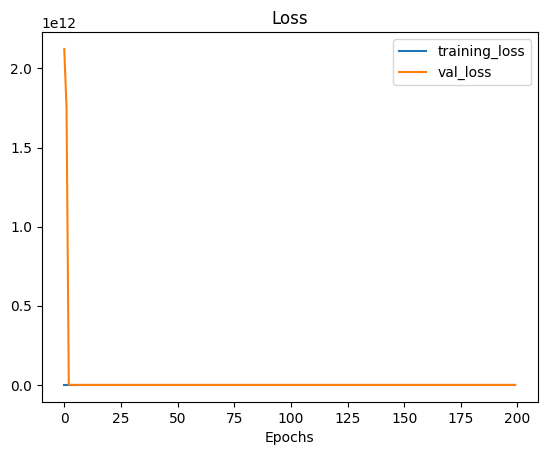

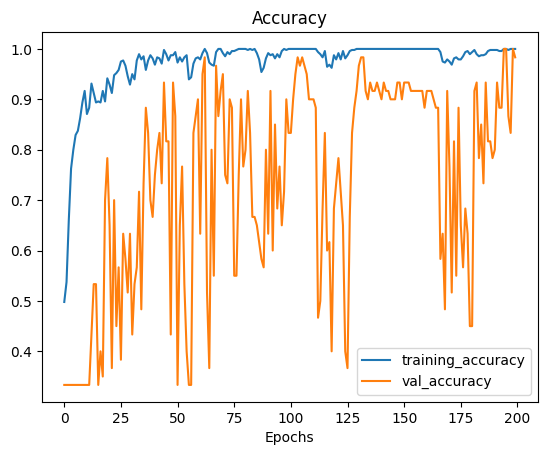

In [ ]:
plot_loss_curves(history_ResNet50_6)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_6.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 2s 2s/step


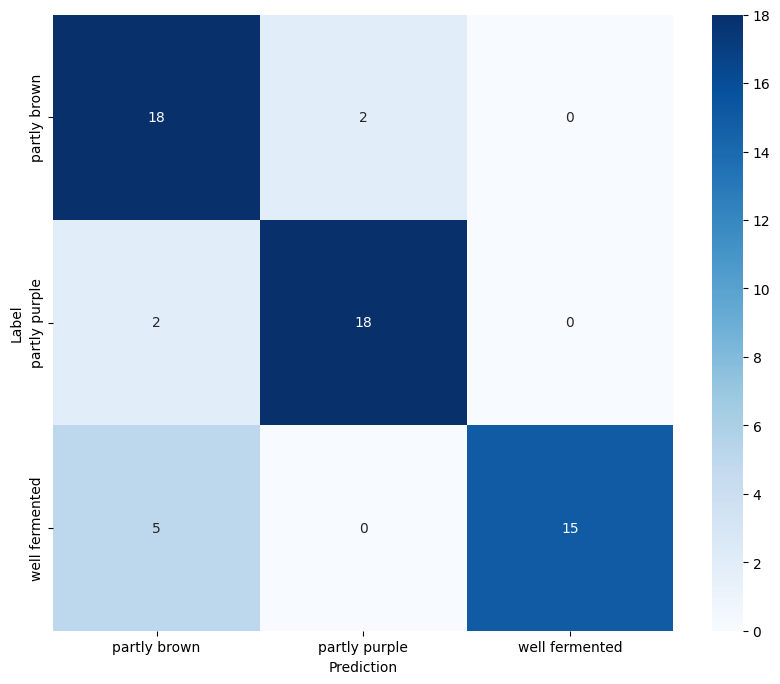

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_6.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-31-4dc47e8d6e9b>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_6.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.72      0.90      0.80        20
 partly purple       0.90      0.90      0.90        20
well fermented       1.00      0.75      0.86        20

      accuracy                           0.85        60
     macro avg       0.87      0.85      0.85        60
  weighted avg       0.87      0.85      0.85        60



In [ ]:
# save model
model_ResNet50_6.save("model_ResNet50_6")

### ResNet50_7

*   Batch Size: 64
*   Learning rate: 0.001
*   Epoch: 200

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_7 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
history_ResNet50_7 = model_ResNet50_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
8/8 [==============================] - 50s 2s/step - loss: 0.7647 - accuracy: 0.7396 - val_loss: 5999.8428 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 7s 648ms/step - loss: 0.2094 - accuracy: 0.9354 - val_loss: 61396.5156 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 8s 661ms/step - loss: 0.2072 - accuracy: 0.9104 - val_loss: 123193.5312 - val_accuracy: 0.3333
Epoch 4/200
8/8 [==============================] - 7s 693ms/step - loss: 0.1084 - accuracy: 0.9604 - val_loss: 172083.0156 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 7s 669ms/step - loss: 0.0635 - accuracy: 0.9771 - val_loss: 32038.7559 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 7s 647ms/step - loss: 0.0285 - accuracy: 0.9917 - val_loss: 8766.2100 - val_accuracy: 0.3333
Epoch 7/200
8/8 [==============================] - 15s 2s/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 3466.2678 - val_accurac

In [ ]:
# data test
loss, accuracy = model_ResNet50_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 674ms/step - loss: 2.9180 - accuracy: 0.4500
Loss : 2.9179718494415283
Accuracy : 0.44999998807907104


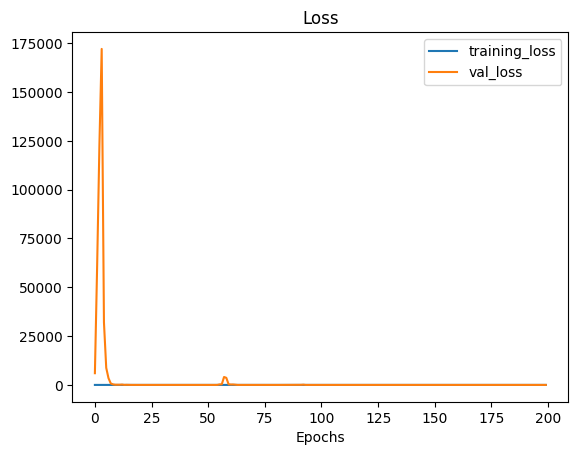

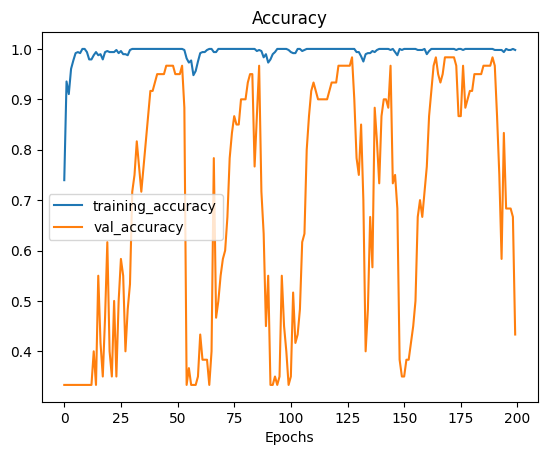

In [ ]:
plot_loss_curves(history_ResNet50_7)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_7.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 1s 121ms/step


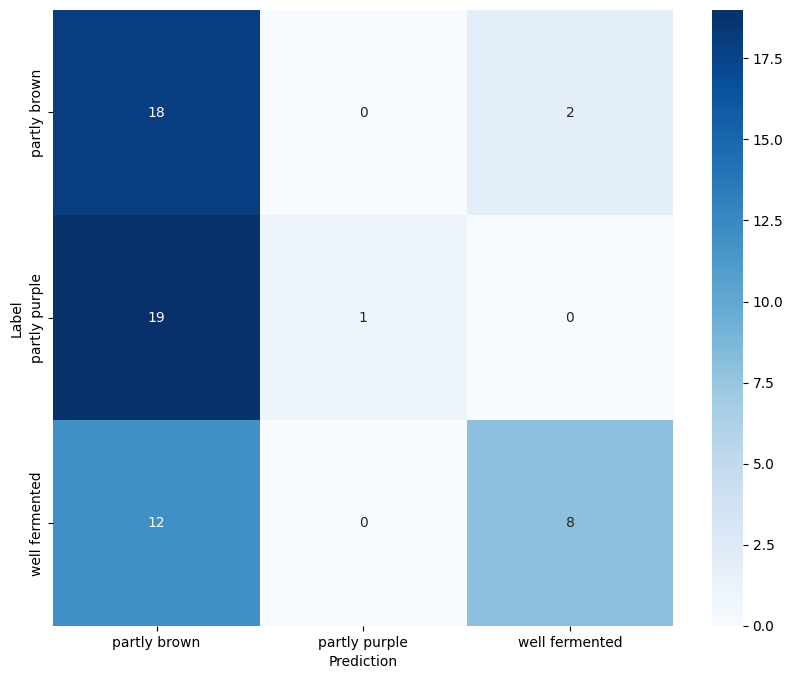

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_7.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-38-bff9b17a81cd>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_7.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.37      0.90      0.52        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.82      0.45      0.58        20

      accuracy                           0.45        60
     macro avg       0.40      0.45      0.37        60
  weighted avg       0.40      0.45      0.37        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_ResNet50_7.save("model_ResNet50_7")

### ResNet50_8

*   Batch Size: 64
*   Learning rate: 0.005
*   Epoch: 200

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_8 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_8)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_8 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_8.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])
history_ResNet50_8 = model_ResNet50_8.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
8/8 [==============================] - 55s 2s/step - loss: 2.3201 - accuracy: 0.5021 - val_loss: 132523887387738112.0000 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 10s 1s/step - loss: 0.9355 - accuracy: 0.7625 - val_loss: 7740515688644608.0000 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 13s 1s/step - loss: 0.7019 - accuracy: 0.7063 - val_loss: 7077238931456.0000 - val_accuracy: 0.3333
Epoch 4/200
8/8 [==============================] - 10s 1s/step - loss: 0.7915 - accuracy: 0.7188 - val_loss: 215098621952.0000 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 10s 1s/step - loss: 0.5389 - accuracy: 0.8271 - val_loss: 4039409408.0000 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 10s 1s/step - loss: 0.3932 - accuracy: 0.8750 - val_loss: 148686512.0000 - val_accuracy: 0.3333
Epoch 7/200
8/8 [==============================] - 10s 1s/step - loss: 0.3032 - accuracy: 0.88

In [ ]:
# data test
loss, accuracy = model_ResNet50_8.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 707ms/step - loss: 1.1889 - accuracy: 0.8167
Loss : 1.1889185905456543
Accuracy : 0.8166666626930237


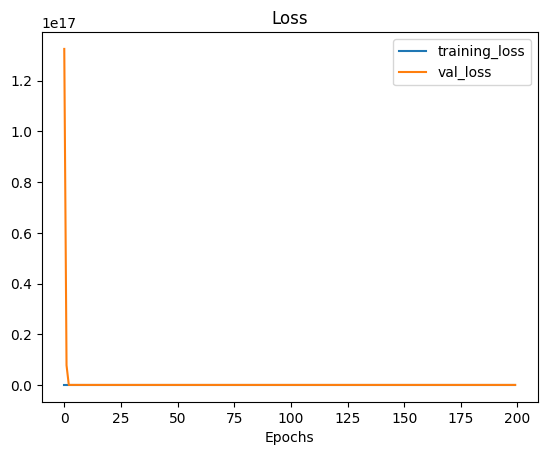

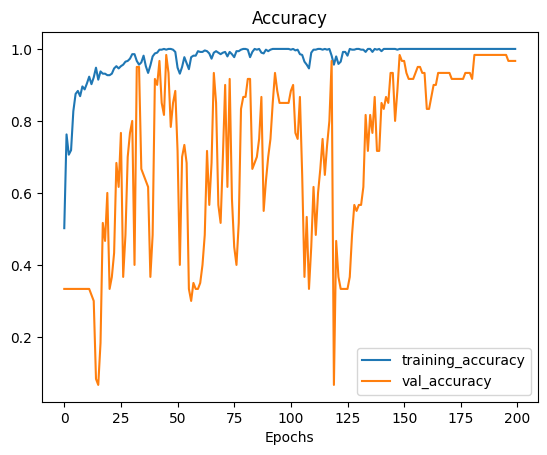

In [ ]:
plot_loss_curves(history_ResNet50_8)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_8.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 1s 121ms/step


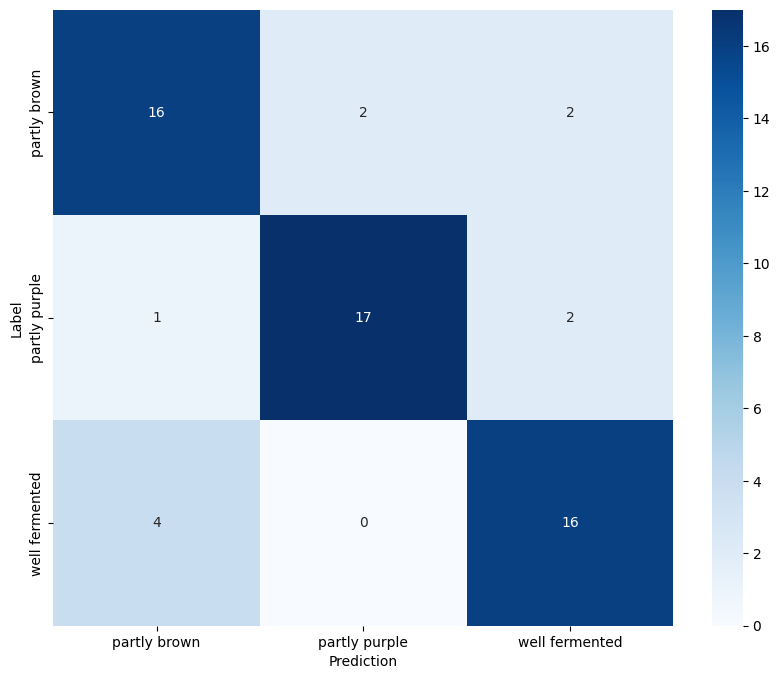

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_ResNet50_8.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-45-d68a8881f221>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_ResNet50_8.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.68      0.85      0.76        20
 partly purple       0.94      0.80      0.86        20
well fermented       0.83      0.75      0.79        20

      accuracy                           0.80        60
     macro avg       0.82      0.80      0.80        60
  weighted avg       0.82      0.80      0.80        60



In [ ]:
# save model
model_ResNet50_8.save("model_ResNet50_8")

## **VGG16**

### VGG16_1

*   Batch Size: 32
*   Learning rate: 0.001
*   Epoch: 100


In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_1 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_1)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_1 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_1.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_1 = model_VGG16_1.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/100
15/15 [==============================] - 85s 2s/step - loss: 128.4993 - accuracy: 0.3229 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 7s 395ms/step - loss: 1.1030 - accuracy: 0.3250 - val_loss: 1.0997 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 10s 518ms/step - loss: 1.1033 - accuracy: 0.3688 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - 8s 408ms/step - loss: 1.0988 - accuracy: 0.3292 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/100
15/15 [==============================] - 8s 403ms/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/100
15/15 [==============================] - 8s 401ms/step - loss: 1.1009 - accuracy: 0.3375 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/100
15/15 [==============================] - 7s 405ms/step - loss: 1

In [ ]:
# data test
loss, accuracy = model_VGG16_1.evaluate(test_data)

2/2 [==============================] - 6s 3s/step - loss: 1.0986 - accuracy: 0.3333


In [ ]:
# Check out the layers in our model
model_VGG16_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________


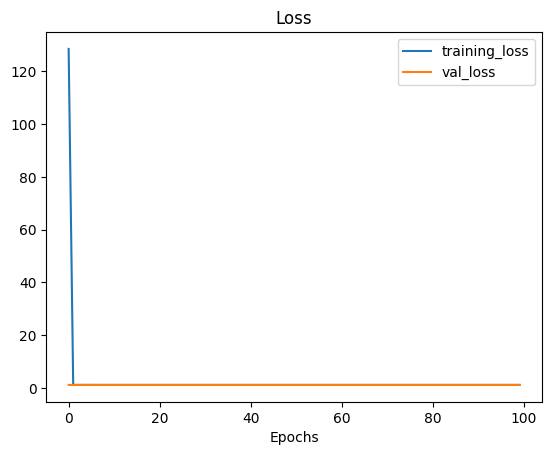

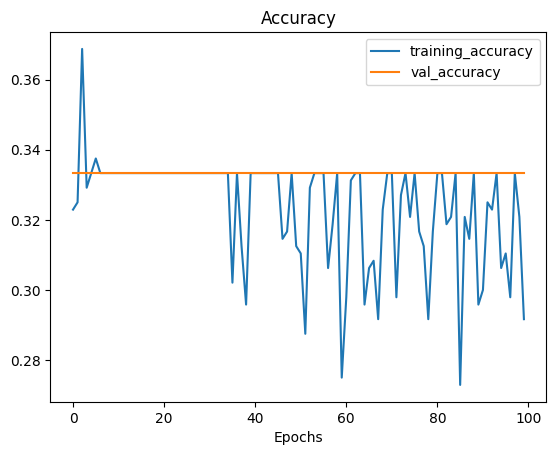

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_1)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_1.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 152ms/step


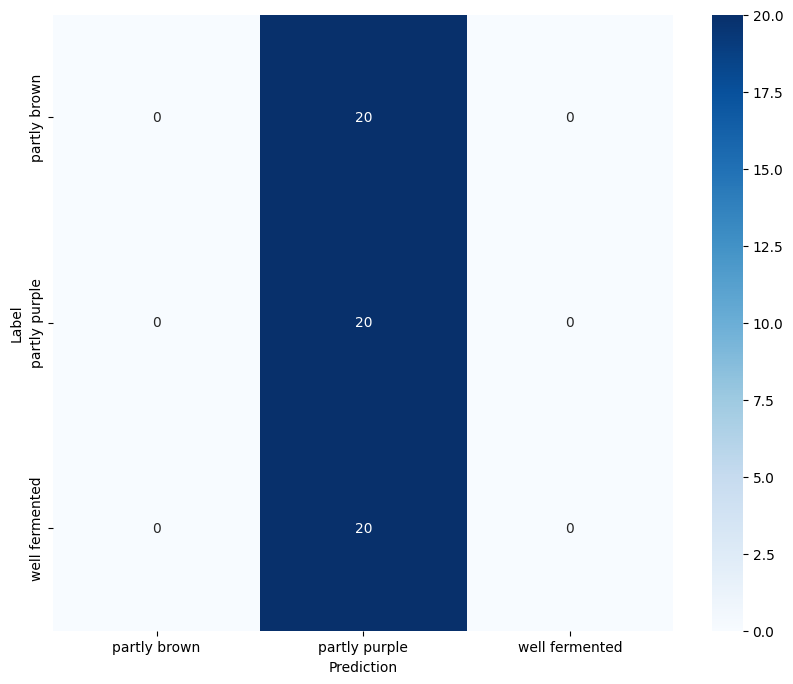

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_1.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-17-f1fb2927d6a0>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_1.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.00      0.00      0.00        20
 partly purple       0.33      1.00      0.50        20
well fermented       0.00      0.00      0.00        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_1.save("model_VGG16_1")

### VGG16_2

*   Batch Size: 32
*   Learning rate: 0.005
*   Epoch: 100

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_2 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_2)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_2 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])

history_VGG16_2 = model_VGG16_2.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/100
15/15 [==============================] - 16s 646ms/step - loss: 207164352.0000 - accuracy: 0.3604 - val_loss: 3.4664 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - 9s 445ms/step - loss: 2.3545 - accuracy: 0.3229 - val_loss: 1.2525 - val_accuracy: 0.3333
Epoch 3/100
15/15 [==============================] - 8s 449ms/step - loss: 1.1548 - accuracy: 0.3500 - val_loss: 1.1347 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - 8s 456ms/step - loss: 1.1334 - accuracy: 0.3125 - val_loss: 1.1253 - val_accuracy: 0.3333
Epoch 5/100
15/15 [==============================] - 9s 460ms/step - loss: 1.1067 - accuracy: 0.3500 - val_loss: 1.1054 - val_accuracy: 0.3333
Epoch 6/100
15/15 [==============================] - 8s 463ms/step - loss: 1.1036 - accuracy: 0.3542 - val_loss: 1.1036 - val_accuracy: 0.3333
Epoch 7/100
15/15 [==============================] - 7s 409ms/step - loss: 1.1224 - accuracy: 0.3229 - val_loss: 1.1302 - val_accurac

In [ ]:
# data test
loss, accuracy = model_VGG16_2.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 111ms/step - loss: 1.0988 - accuracy: 0.3333
Loss : 1.098763346672058
Accuracy : 0.3333333432674408


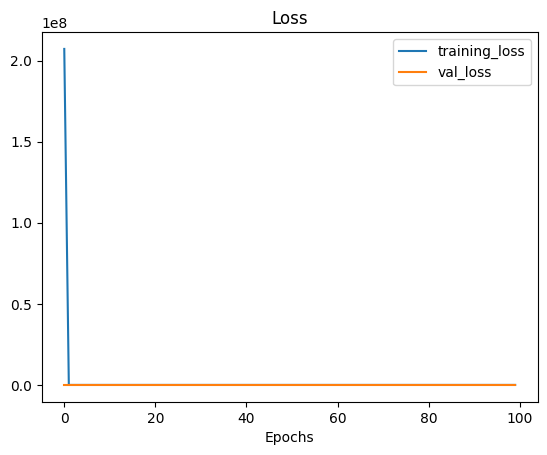

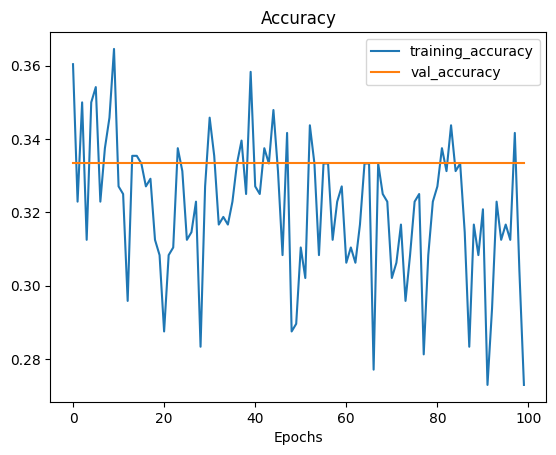

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_2)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_2.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 143ms/step


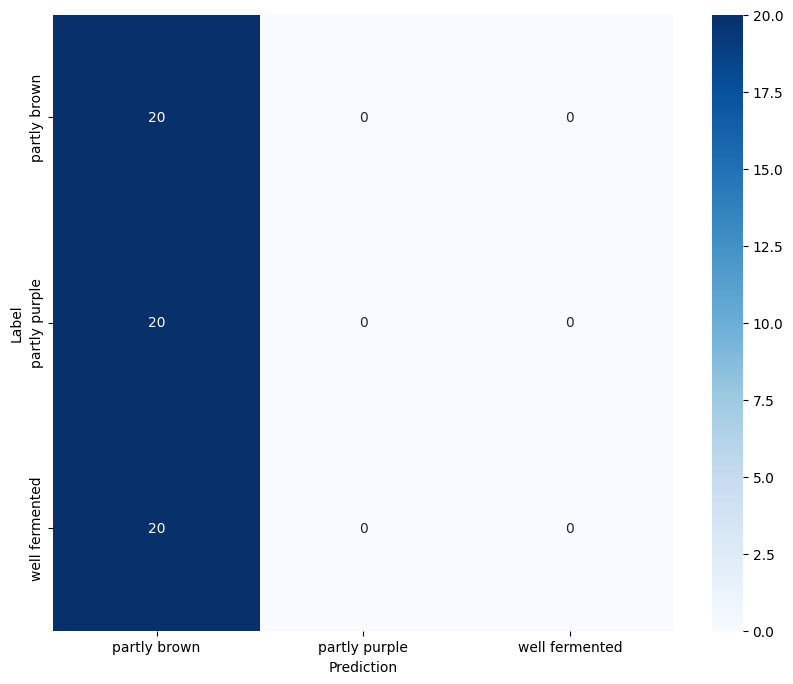

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_2.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-24-059023874a2d>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_2.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.33      1.00      0.50        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.00      0.00      0.00        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_2.save("model_VGG16_2")

### VGG16_3

*   Batch Size: 64
*   Learning rate: 0.001
*   Epoch: 100

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_3 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_3)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_3 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_3.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_3 = model_VGG16_3.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/100
8/8 [==============================] - 48s 3s/step - loss: 220.1083 - accuracy: 0.3438 - val_loss: 4.5777 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 8s 842ms/step - loss: 4.8607 - accuracy: 0.3229 - val_loss: 1.1121 - val_accuracy: 0.2667
Epoch 3/100
8/8 [==============================] - 7s 745ms/step - loss: 1.1016 - accuracy: 0.3167 - val_loss: 1.1845 - val_accuracy: 0.3333
Epoch 4/100
8/8 [==============================] - 9s 977ms/step - loss: 1.1032 - accuracy: 0.3375 - val_loss: 1.1003 - val_accuracy: 0.2500
Epoch 5/100
8/8 [==============================] - 8s 869ms/step - loss: 1.1003 - accuracy: 0.3250 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/100
8/8 [==============================] - 9s 973ms/step - loss: 1.1093 - accuracy: 0.3438 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/100
8/8 [==============================] - 8s 761ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 8/100
8

In [ ]:
# data test
loss, accuracy = model_VGG16_3.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 647ms/step - loss: 1.0986 - accuracy: 0.3333
Loss : 1.0986144542694092
Accuracy : 0.3333333432674408


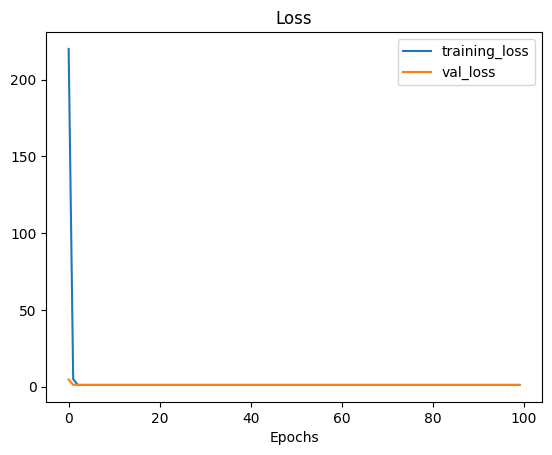

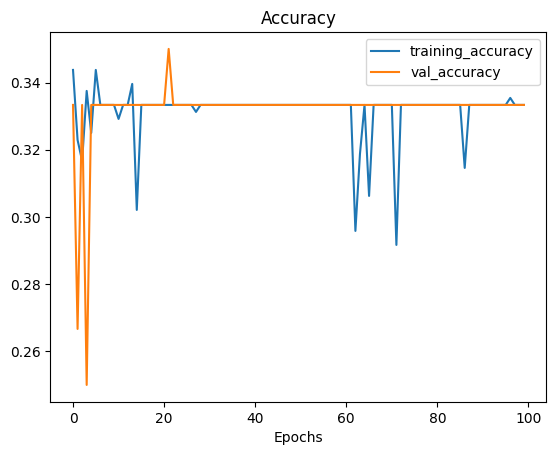

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_3)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_3.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 0s 112ms/step


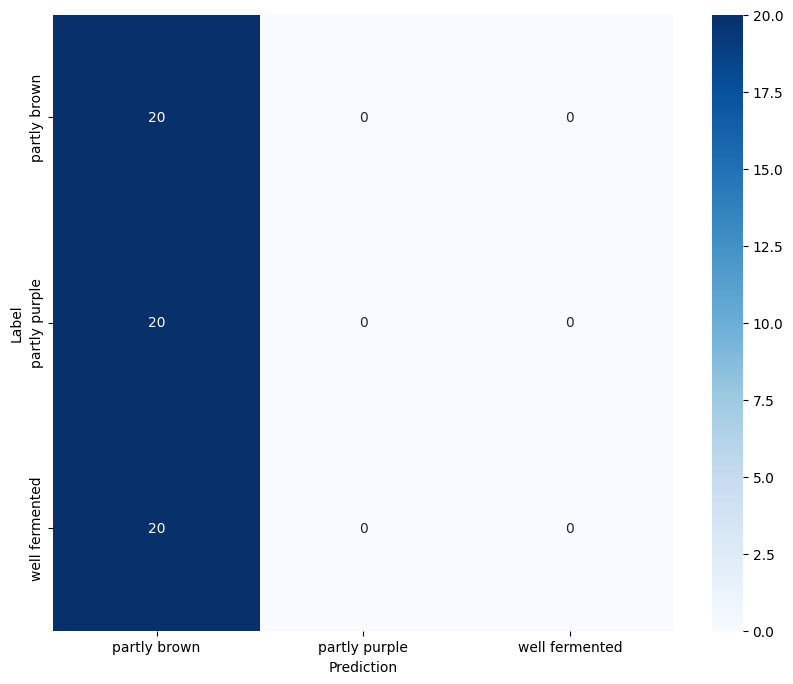

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_3.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-31-e6d6f45ed02d>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_3.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.33      1.00      0.50        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.00      0.00      0.00        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_3.save("model_VGG16_3")

### VGG16_4

*   Batch Size: 64
*   Learning rate: 0.005
*   Epoch: 100

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_4 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_4)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_4 = Model(inputs=inputs, outputs=outputs)

epochs = 100
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_4.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])

history_VGG16_4 = model_VGG16_4.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/100
8/8 [==============================] - 15s 1s/step - loss: 2211772928.0000 - accuracy: 0.3292 - val_loss: 6.9679 - val_accuracy: 0.3333
Epoch 2/100
8/8 [==============================] - 8s 808ms/step - loss: 2.6348 - accuracy: 0.3292 - val_loss: 1.3963 - val_accuracy: 0.3333
Epoch 3/100
8/8 [==============================] - 9s 984ms/step - loss: 1.2977 - accuracy: 0.3542 - val_loss: 1.2681 - val_accuracy: 0.3333
Epoch 4/100
8/8 [==============================] - 8s 790ms/step - loss: 1.1805 - accuracy: 0.3396 - val_loss: 1.1078 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 1.1065 - accuracy: 0.3333 - val_loss: 1.1030 - val_accuracy: 0.3333
Epoch 6/100
8/8 [==============================] - 7s 713ms/step - loss: 1.1084 - accuracy: 0.3333 - val_loss: 1.1060 - val_accuracy: 0.3333
Epoch 7/100
8/8 [==============================] - 8s 931ms/step - loss: 1.1116 - accuracy: 0.3083 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 8/

In [ ]:
# data test
loss, accuracy = model_VGG16_4.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 0s 476ms/step - loss: 1.0996 - accuracy: 0.3333
Loss : 1.0995514392852783
Accuracy : 0.3333333432674408


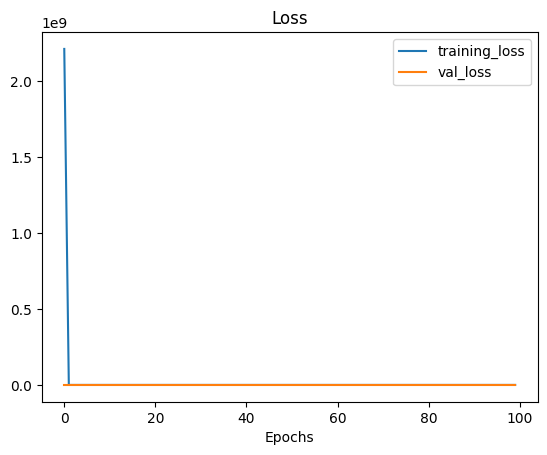

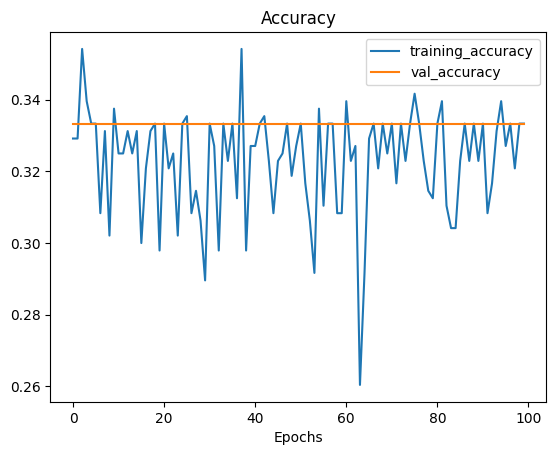

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_4)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_4.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 0s 106ms/step


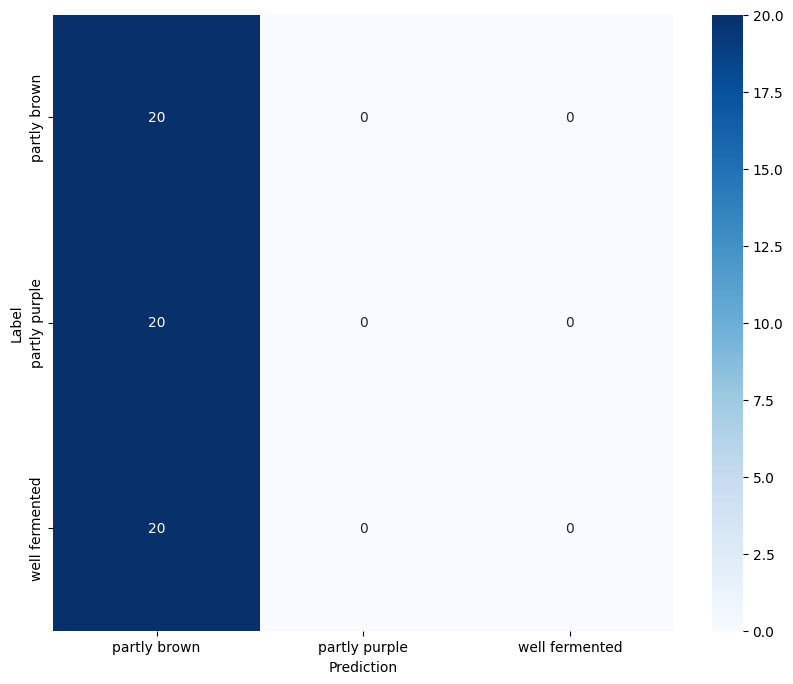

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_4.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-38-45544a6dd041>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_4.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.33      1.00      0.50        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.00      0.00      0.00        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_4.save("model_VGG16_4")

### VGG16_5

*   Batch Size: 32
*   Learning rate: 0.001
*   Epoch: 200

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_5 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_5)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_5 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_5.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_5 = model_VGG16_5.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
15/15 [==============================] - 80s 1s/step - loss: 102.1610 - accuracy: 0.3271 - val_loss: 1.1164 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 9s 447ms/step - loss: 1.1095 - accuracy: 0.2854 - val_loss: 1.1004 - val_accuracy: 0.3167
Epoch 3/200
15/15 [==============================] - 8s 470ms/step - loss: 1.1011 - accuracy: 0.3333 - val_loss: 1.0963 - val_accuracy: 0.2833
Epoch 4/200
15/15 [==============================] - 8s 454ms/step - loss: 1.0996 - accuracy: 0.3292 - val_loss: 1.0944 - val_accuracy: 0.3833
Epoch 5/200
15/15 [==============================] - 8s 421ms/step - loss: 1.0968 - accuracy: 0.3479 - val_loss: 1.0945 - val_accuracy: 0.3167
Epoch 6/200
15/15 [==============================] - 8s 429ms/step - loss: 1.0999 - accuracy: 0.3583 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 9s 416ms/step - loss: 1.

In [ ]:
# data test
loss, accuracy = model_VGG16_5.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 5s 2s/step - loss: 1.0986 - accuracy: 0.3167
Loss : 1.0986263751983643
Accuracy : 0.3166666626930237


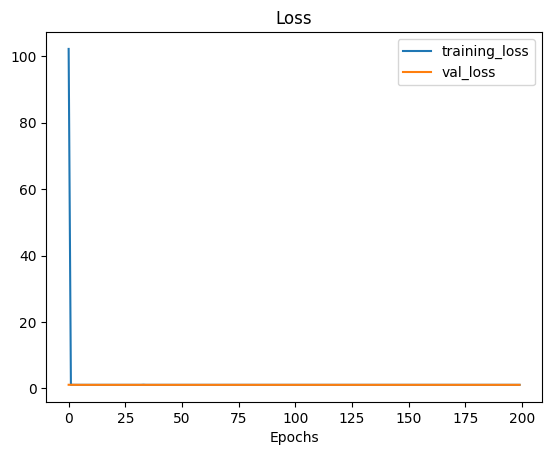

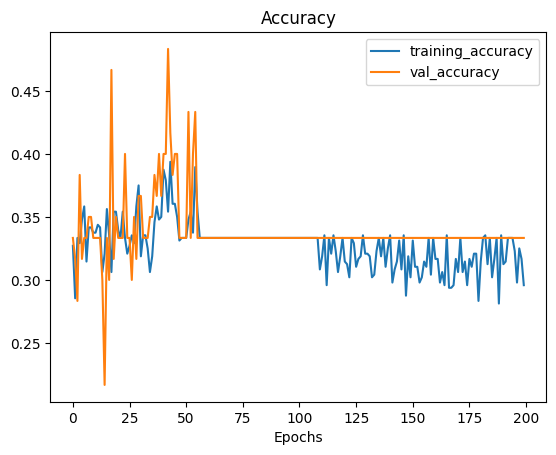

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_5)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_5.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 164ms/step


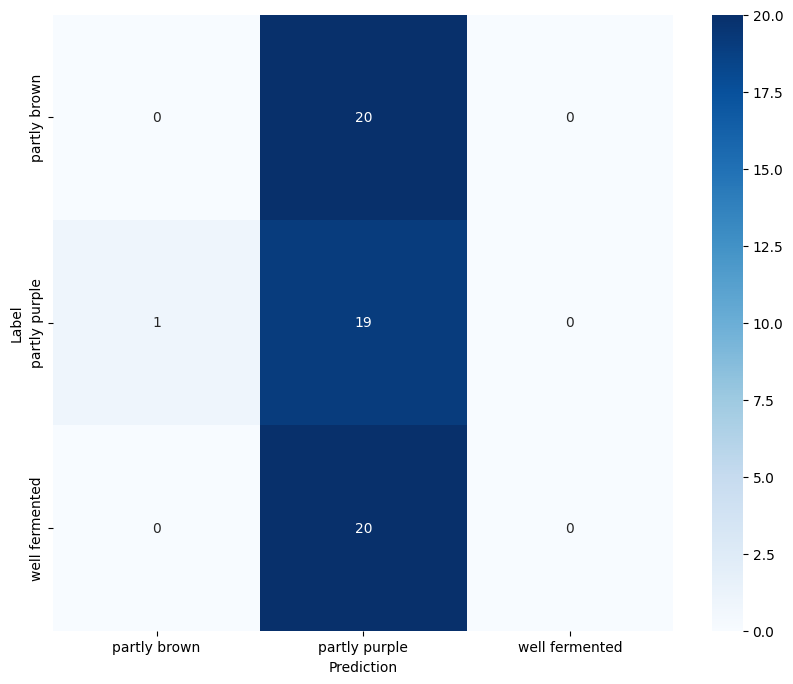

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_5.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-16-f3b5a4236a0d>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_5.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.00      0.00      0.00        20
 partly purple       0.32      0.95      0.48        20
well fermented       0.00      0.00      0.00        20

      accuracy                           0.32        60
     macro avg       0.11      0.32      0.16        60
  weighted avg       0.11      0.32      0.16        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_5.save("model_VGG16_5")

### VGG16_6

*   Batch Size: 32
*   Learning rate: 0.005
*   Epoch: 200

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_6 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])

history_VGG16_6 = model_VGG16_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 14s 571ms/step - loss: 261975744.0000 - accuracy: 0.3458 - val_loss: 6.8072 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 8s 437ms/step - loss: 4.1577 - accuracy: 0.3292 - val_loss: 1.3708 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 8s 443ms/step - loss: 1.1414 - accuracy: 0.3688 - val_loss: 1.1039 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 8s 440ms/step - loss: 1.1143 - accuracy: 0.3250 - val_loss: 1.1019 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 7s 395ms/step - loss: 1.1082 - accuracy: 0.3292 - val_loss: 1.1181 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 7s 398ms/step - loss: 1.1171 - accuracy: 0.3125 - val_loss: 1.1021 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 9s 529ms/step - loss: 1.1054 - accuracy: 0.3083 - val_loss: 1.0990 - val_accurac

In [ ]:
# data test
loss, accuracy = model_VGG16_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 126ms/step - loss: 1.0994 - accuracy: 0.3333
Loss : 1.099364161491394
Accuracy : 0.3333333432674408


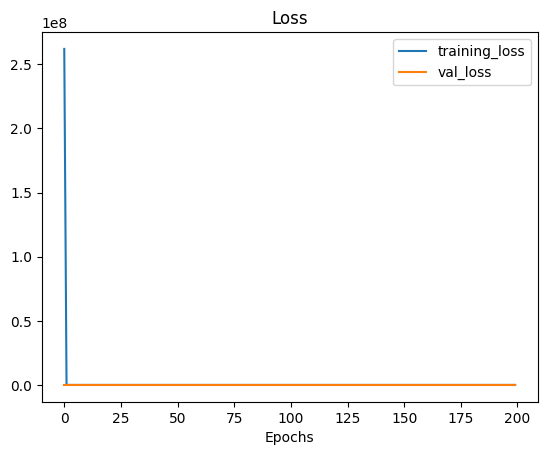

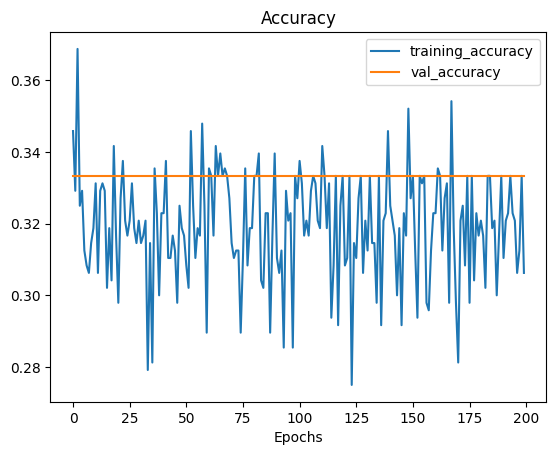

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_6)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_6.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 142ms/step


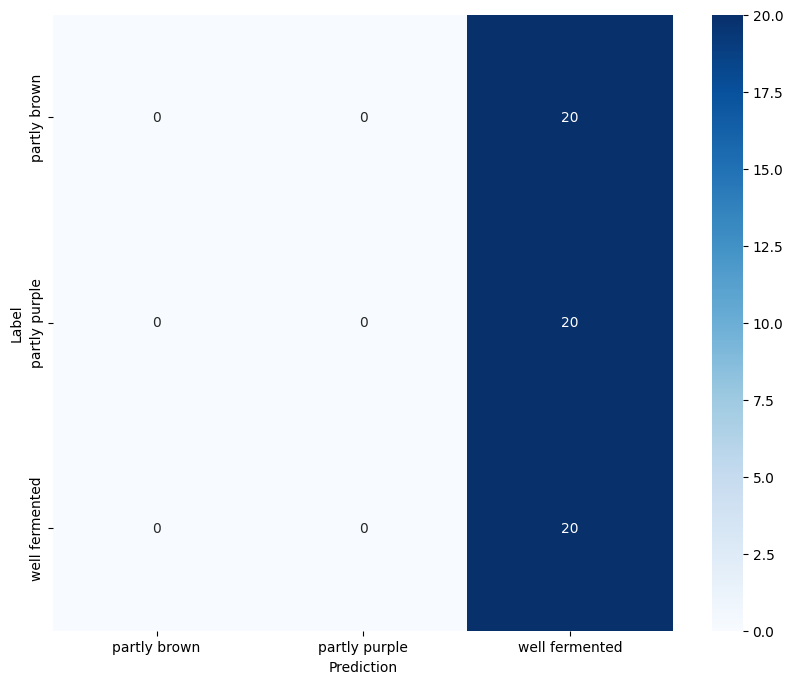

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_6.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-23-6867175ec3e1>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_6.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.00      0.00      0.00        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.33      1.00      0.50        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_6.save("model_VGG16_6")

### VGG16_7

*   Batch Size: 64
*   Learning rate: 0.001
*   Epoch: 200

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
8/8 [==============================] - 107s 5s/step - loss: 13.1931 - accuracy: 0.3458 - val_loss: 1.2127 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 8s 723ms/step - loss: 1.3829 - accuracy: 0.3417 - val_loss: 1.6220 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 9s 947ms/step - loss: 1.1822 - accuracy: 0.3313 - val_loss: 1.0968 - val_accuracy: 0.3667
Epoch 4/200
8/8 [==============================] - 7s 763ms/step - loss: 1.1021 - accuracy: 0.3292 - val_loss: 1.0981 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 10s 968ms/step - loss: 1.0973 - accuracy: 0.3292 - val_loss: 1.0913 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 7s 737ms/step - loss: 1.0929 - accuracy: 0.3250 - val_loss: 1.0928 - val_accuracy: 0.3000
Epoch 7/200
8/8 [==============================] - 10s 1s/step - loss: 1.0870 - accuracy

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 7s 7s/step - loss: 1.2088 - accuracy: 0.8833
Loss : 1.2088390588760376
Accuracy : 0.8833333253860474


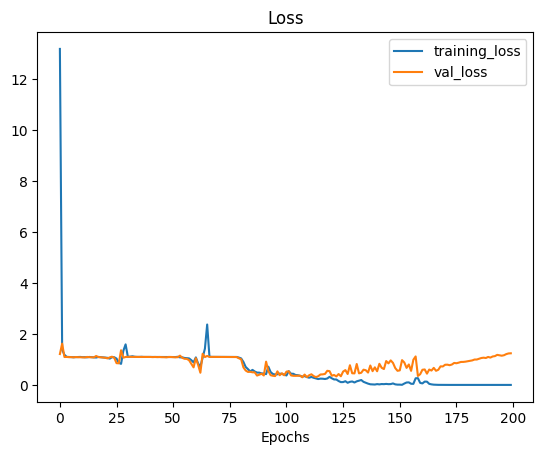

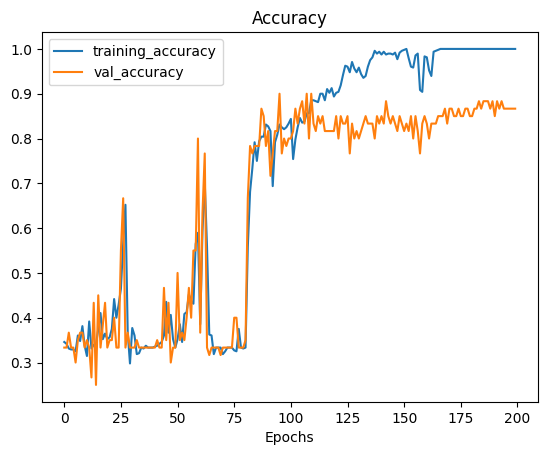

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_7)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_7.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 4s 4s/step


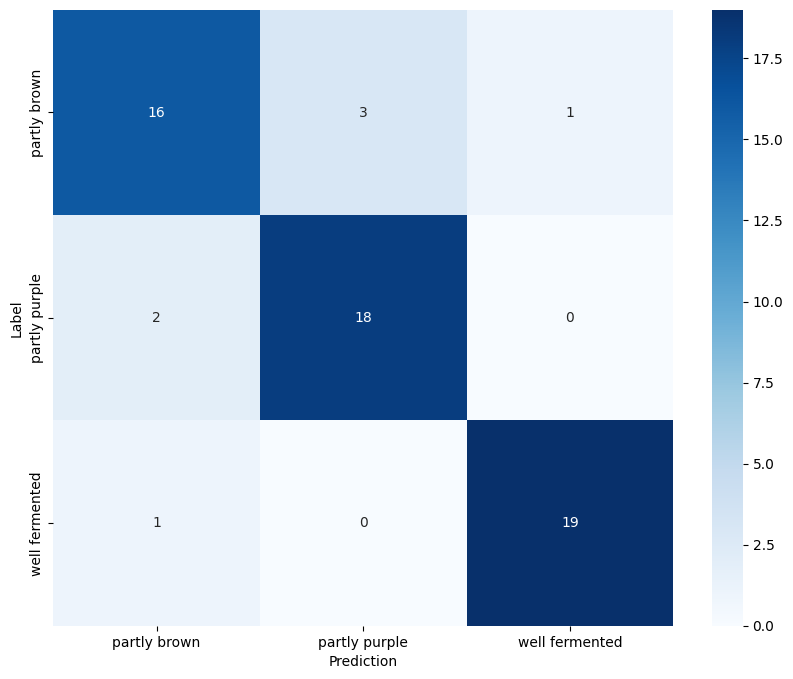

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_7.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-16-1a2482888ef9>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_7.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.80      0.80      0.80        20
 partly purple       0.85      0.85      0.85        20
well fermented       0.95      0.95      0.95        20

      accuracy                           0.87        60
     macro avg       0.87      0.87      0.87        60
  weighted avg       0.87      0.87      0.87        60



In [ ]:
# save model
model_VGG16_7.save("model_VGG16_7")

### VGG16_8

*   Batch Size: 64
*   Learning rate: 0.005
*   Epoch: 200

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_8 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_8)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_8 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_8.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])

history_VGG16_8 = model_VGG16_8.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
8/8 [==============================] - 110s 4s/step - loss: 641157568.0000 - accuracy: 0.3458 - val_loss: 90.8247 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 8s 785ms/step - loss: 13.0856 - accuracy: 0.3417 - val_loss: 1.2130 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 7s 719ms/step - loss: 1.2723 - accuracy: 0.3479 - val_loss: 1.2409 - val_accuracy: 0.3333
Epoch 4/200
8/8 [==============================] - 9s 944ms/step - loss: 1.1724 - accuracy: 0.3250 - val_loss: 1.1286 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 8s 782ms/step - loss: 1.1242 - accuracy: 0.3104 - val_loss: 1.1080 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 8s 909ms/step - loss: 1.1021 - accuracy: 0.3458 - val_loss: 1.1051 - val_accuracy: 0.3333
Epoch 7/200
8/8 [==============================] - 8s 794ms/step - loss: 1.1049 

In [ ]:
# data test
loss, accuracy = model_VGG16_8.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 7s 7s/step - loss: 1.0996 - accuracy: 0.3333
Loss : 1.0995736122131348
Accuracy : 0.3333333432674408


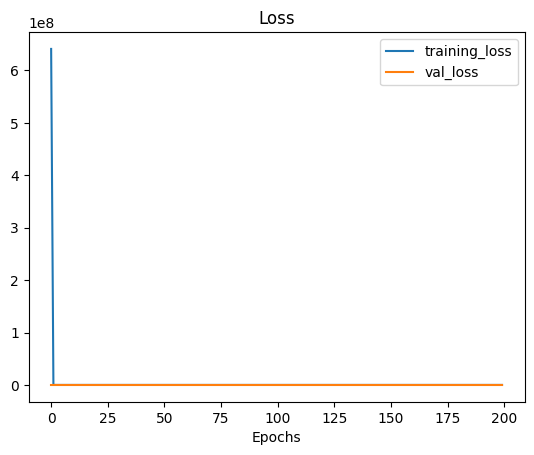

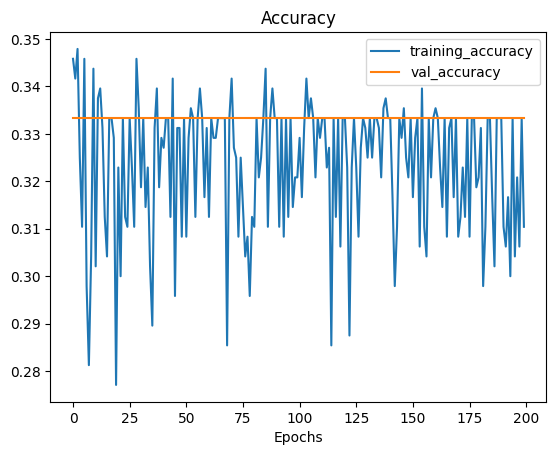

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_8)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_8.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 4s 4s/step


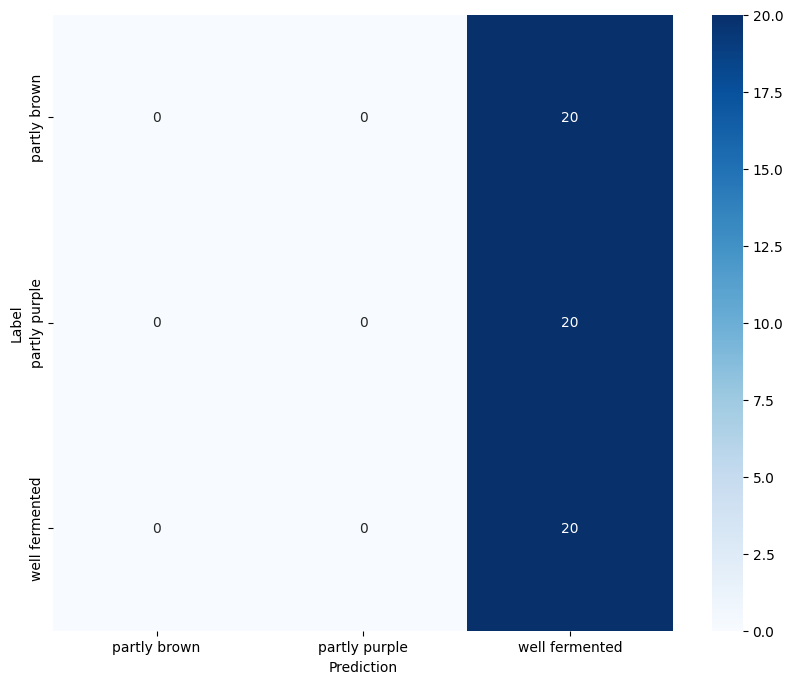

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_dir, # Put your path here
     target_size=(224, 224),
    batch_size=64,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model_VGG16_8.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 60 images belonging to 3 classes.


<ipython-input-17-22a371f32cf8>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_VGG16_8.predict_generator(test_data_generator, steps=test_steps_per_epoch)


                precision    recall  f1-score   support

  partly brown       0.00      0.00      0.00        20
 partly purple       0.00      0.00      0.00        20
well fermented       0.33      1.00      0.50        20

      accuracy                           0.33        60
     macro avg       0.11      0.33      0.17        60
  weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save model
model_VGG16_8.save("model_VGG16_8")

# Load Model

In [ ]:
from tensorflow.keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/Kakao/model/Otsu/model_ResNet50_6')

In [ ]:
batch_size = 32
test_data = prepare(list_test_ds, batch_size, shuffle=False)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 2s 2s/step


In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

z = confusion_mtx[::-1]
x = class_names
y =  x[::-1].copy()
heatmap = go.Heatmap(z=z, x=x, y=y, colorscale='Blues')

annotations = []
for i, row in enumerate(confusion_mtx.numpy().T):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x": x[i],
                "y": x[j],
                "font": {"color": "black", "size" : 55},
                "text": str(value),
                "xref": "x1",
                "yref": "y1",
                "showarrow": False
            }
        )
layout = {
      "title": 'a',
      "xaxis": {"title": "Predictions"},
      "yaxis": {"title": "Labels"},
      "annotations": annotations
  }
fig = go.Figure(data=[heatmap], layout=layout)
fig.update_yaxes(tickangle=-90)
fig.update_layout(
    width=800, height=800,
    font=dict(
      family="Arial", size=30,),
)
# show the figure
fig.show()

In [ ]:
from tensorflow.keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/Kakao/model/otsu (3)/model_VGG16_7')

In [ ]:
batch_size = 64
test_data = prepare(list_test_ds, batch_size, shuffle=False)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 9s 4s/step


In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

z = confusion_mtx[::-1]
x = class_names
y =  x[::-1].copy()
heatmap = go.Heatmap(z=z, x=x, y=y, colorscale='Blues')

annotations = []
for i, row in enumerate(confusion_mtx.numpy().T):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x": x[i],
                "y": x[j],
                "font": {"color": "black", "size" : 55},
                "text": str(value),
                "xref": "x1",
                "yref": "y1",
                "showarrow": False
            }
        )
layout = {
      "title": 'a',
      "xaxis": {"title": "Predictions"},
      "yaxis": {"title": "Labels"},
      "annotations": annotations
  }
fig = go.Figure(data=[heatmap], layout=layout)
fig.update_yaxes(tickangle=-90)
fig.update_layout(
    width=800, height=800,
    font=dict(
      family="Arial", size=30,),
)
# show the figure
fig.show()

# Run Best Model

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves_2(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylim([0,3])
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves_3(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylim([0,4])
  plt.legend()


## ResNet50_6

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/200
15/15 [==============================] - 217s 2s/step - loss: 2.3391 - accuracy: 0.5063 - val_loss: 8712162381922304.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 8s 428ms/step - loss: 1.0681 - accuracy: 0.6333 - val_loss: 17211698708480.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 8s 426ms/step - loss: 0.9693 - accuracy: 0.6208 - val_loss: 995199360.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 9s 432ms/step - loss: 0.6609 - accuracy: 0.7458 - val_loss: 116784488.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 9s 499ms/step - loss: 0.5678 - accuracy: 0.7667 - val_loss: 2527212.5000 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 8s 437ms/step - loss: 0.4740 - accuracy: 0.7854 - val_loss: 261012.3594 - val_accuracy: 0.3333
Epoch 7/200
15/15 [====

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 122ms/step - loss: 2.0333 - accuracy: 0.5833
Loss : 2.0332908630371094
Accuracy : 0.5833333134651184


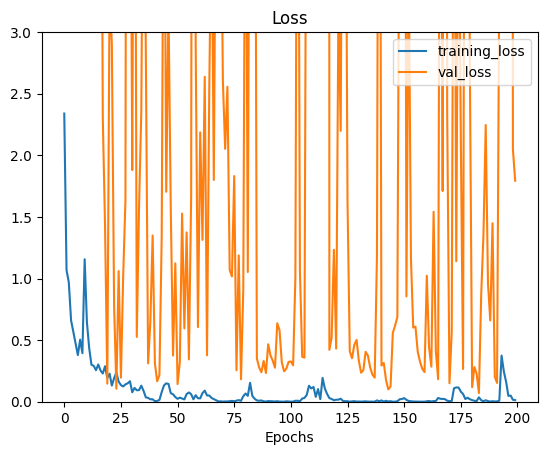

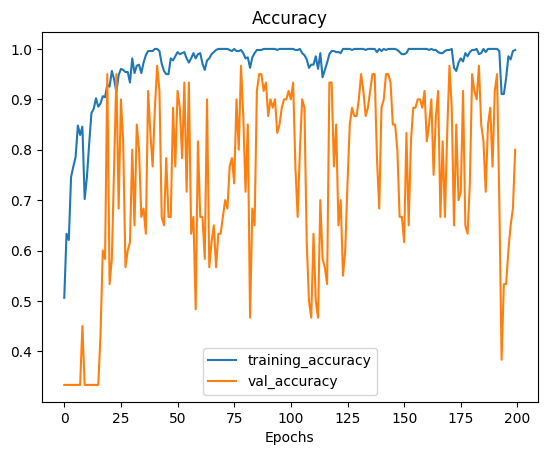

In [ ]:
plot_loss_curves_2(history_ResNet50_6)

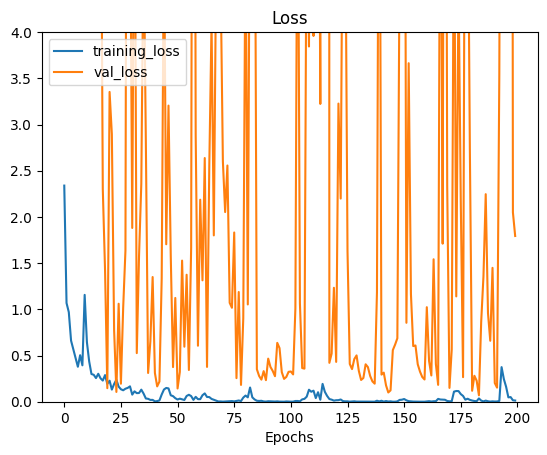

In [ ]:
plot_loss_curves_3(history_ResNet50_6)

## VGG16_7

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/200
8/8 [==============================] - 65s 4s/step - loss: 33.3424 - accuracy: 0.3688 - val_loss: 1.4054 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 9s 870ms/step - loss: 1.3708 - accuracy: 0.3250 - val_loss: 1.1734 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 8s 817ms/step - loss: 1.1003 - accuracy: 0.3479 - val_loss: 1.1399 - val_accuracy: 0.3333
Epoch 4/200
8/8 [==============================] - 8s 832ms/step - loss: 1.1101 - accuracy: 0.3417 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 8s 800ms/step - loss: 1.0984 - accuracy: 0.3708 - val_loss: 1.0985 - val_accuracy: 0.2500
Epoch 6/200
8/8 [==============================] - 7s 782ms/step - loss: 1.0983 - accuracy: 0.3562 - val_loss: 1.0988 - val_accuracy: 0.3167
Epoch 7/200
8/8 [==============================] - 8s 802ms/step - loss: 1.0983 - accuracy

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 20s 20s/step - loss: 0.8922 - accuracy: 0.8000
Loss : 0.8922046422958374
Accuracy : 0.800000011920929


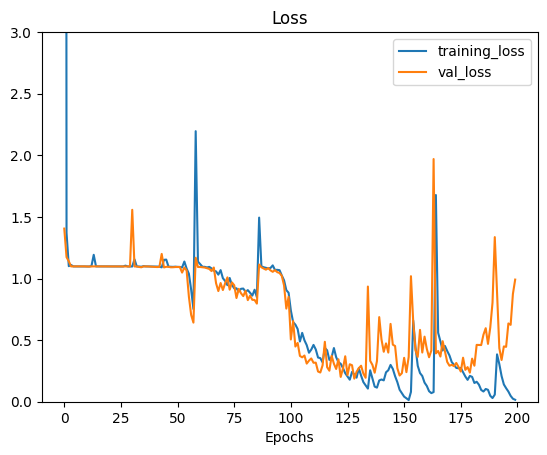

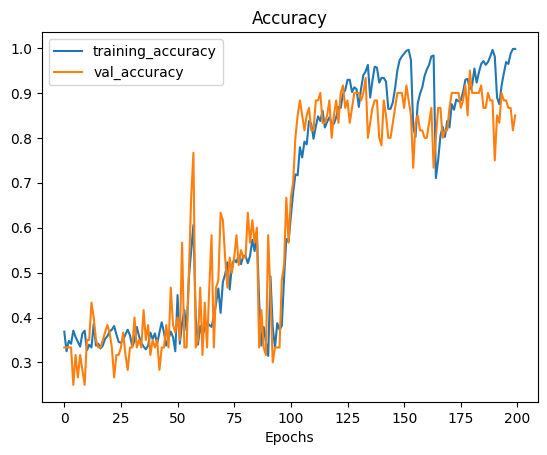

In [ ]:
plot_loss_curves_2(history_VGG16_7)

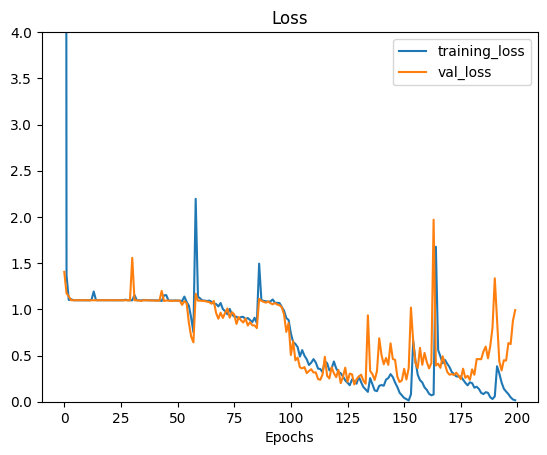

In [ ]:
plot_loss_curves_3(history_VGG16_7)

# Trial Error

## ResNet50_6

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves_4(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylim([0,3])
  plt.legend()

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 55s 1s/step - loss: 0.6871 - accuracy: 0.6958 - val_loss: 1.1421 - val_accuracy: 0.4000
Epoch 2/200
15/15 [==============================] - 7s 366ms/step - loss: 0.0527 - accuracy: 0.9875 - val_loss: 1.2766 - val_accuracy: 0.5667
Epoch 3/200
15/15 [==============================] - 7s 360ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 1.8327 - val_accuracy: 0.4667
Epoch 4/200
15/15 [==============================] - 7s 380ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 1.8775 - val_accuracy: 0.4833
Epoch 5/200
15/15 [==============================] - 7s 360ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.2763 - val_accuracy: 0.6000
Epoch 6/200
15/15 [==============================] - 9s 499ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.1216 - val_accuracy: 0.6667
Epoch 7/200
15/15 [==============================] - 11s 706ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0315 - val_accuracy: 0.7333


In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 101ms/step - loss: 0.7624 - accuracy: 0.8000
Loss : 0.7624051570892334
Accuracy : 0.800000011920929


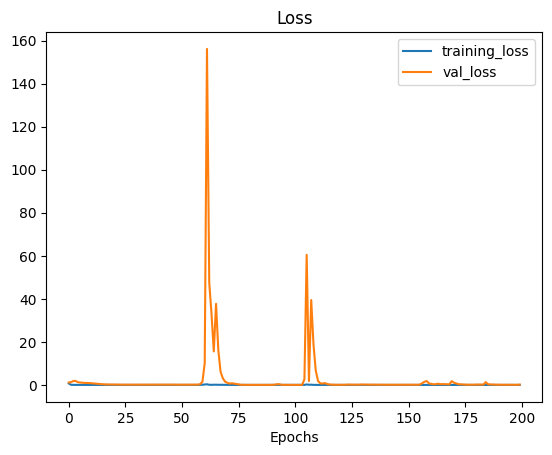

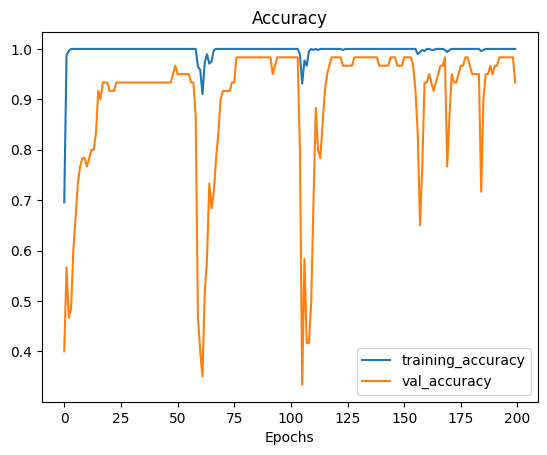

In [ ]:
plot_loss_curves(history_ResNet50_6)

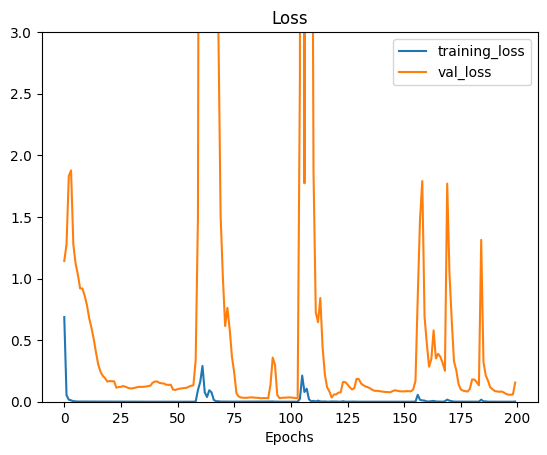

In [ ]:
plot_loss_curves_4(history_ResNet50_6)

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 74s 786ms/step - loss: 0.7893 - accuracy: 0.7292 - val_loss: 1100.2429 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 7s 334ms/step - loss: 0.3454 - accuracy: 0.8750 - val_loss: 2497.1399 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 10s 607ms/step - loss: 0.2719 - accuracy: 0.9167 - val_loss: 391.6460 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 10s 601ms/step - loss: 0.1660 - accuracy: 0.9312 - val_loss: 380.9627 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 11s 613ms/step - loss: 0.1162 - accuracy: 0.9625 - val_loss: 115.6835 - val_accuracy: 0.3833
Epoch 6/200
15/15 [==============================] - 7s 358ms/step - loss: 0.1513 - accuracy: 0.9479 - val_loss: 125.0527 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 12s 714ms/step - loss: 0.0493 - accuracy: 0.9875 - val_loss: 16.2184 - 

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 118ms/step - loss: 0.7998 - accuracy: 0.7500
Loss : 0.7998490929603577
Accuracy : 0.75


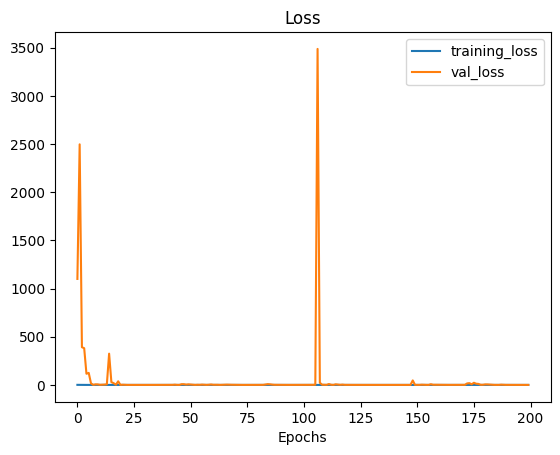

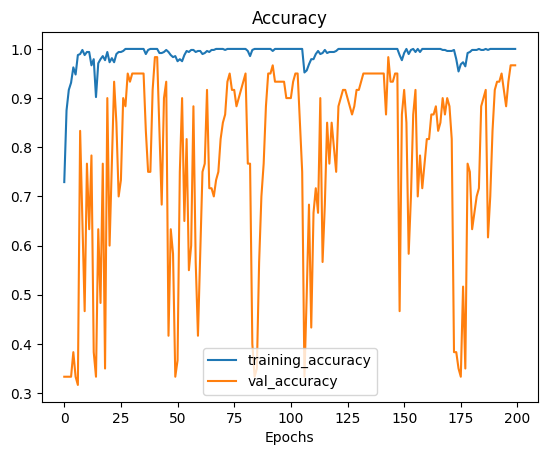

In [ ]:
plot_loss_curves(history_ResNet50_6)

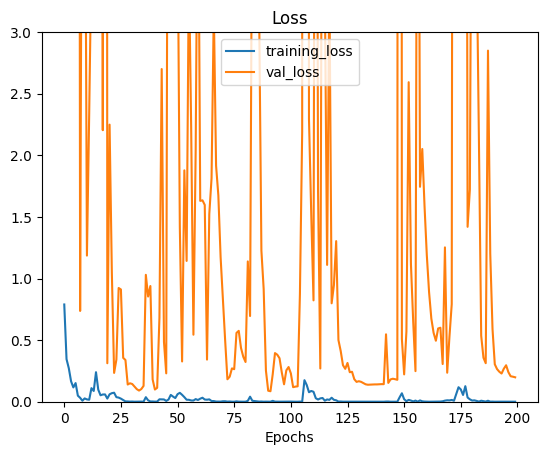

In [ ]:
plot_loss_curves_4(history_ResNet50_6)

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.01), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/200
15/15 [==============================] - 242s 2s/step - loss: 3.0469 - accuracy: 0.4125 - val_loss: 796798140865839104.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 8s 428ms/step - loss: 1.0795 - accuracy: 0.6708 - val_loss: 745872476340224.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 7s 417ms/step - loss: 0.6746 - accuracy: 0.8333 - val_loss: 1144947212288.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 7s 420ms/step - loss: 0.6304 - accuracy: 0.8438 - val_loss: 1572365440.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 8s 419ms/step - loss: 0.5254 - accuracy: 0.8375 - val_loss: 12928314.0000 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 8s 421ms/step - loss: 0.5131 - accuracy: 0.8562 - val_loss: 507997.6250 - val_accuracy: 0.3333
Epoch 7/200
15

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 25s 11s/step - loss: 0.9421 - accuracy: 0.8167
Loss : 0.9421356320381165
Accuracy : 0.8166666626930237


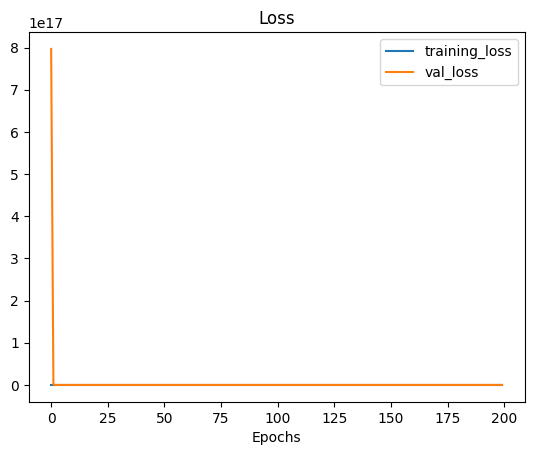

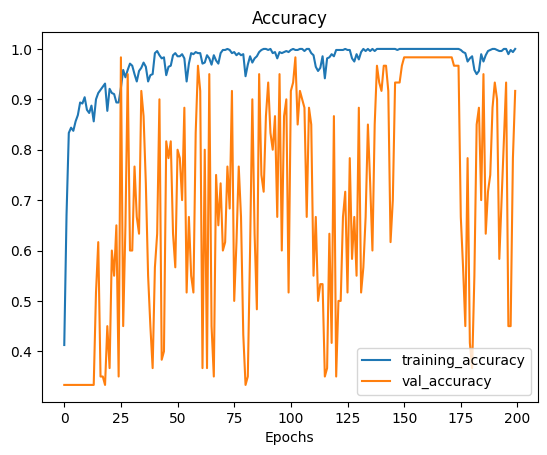

In [ ]:
plot_loss_curves(history_ResNet50_6)

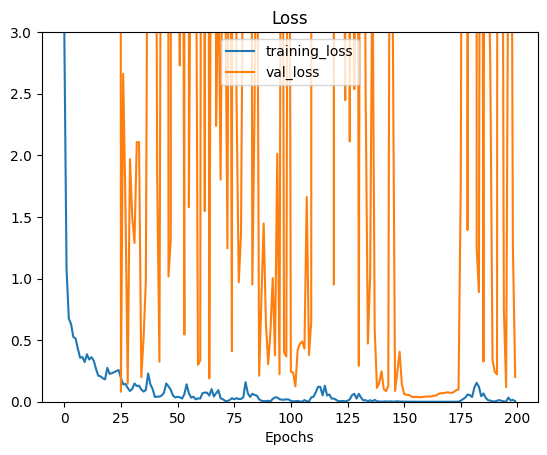

In [ ]:
plot_loss_curves_4(history_ResNet50_6)

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.1), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 47s 561ms/step - loss: 8.7000 - accuracy: 0.4208 - val_loss: 666239506183665684112736256.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 12s 735ms/step - loss: 0.6416 - accuracy: 0.7333 - val_loss: 125459679798099968.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 10s 625ms/step - loss: 0.5274 - accuracy: 0.7667 - val_loss: 1139449135104.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 11s 637ms/step - loss: 0.4974 - accuracy: 0.7771 - val_loss: 1965217408.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 11s 660ms/step - loss: 0.4865 - accuracy: 0.8167 - val_loss: 36044008.0000 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 10s 627ms/step - loss: 0.4228 - accuracy: 0.8083 - val_loss: 3818290.2500 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 11s 67

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 151ms/step - loss: 2.7845 - accuracy: 0.7167
Loss : 2.7845075130462646
Accuracy : 0.7166666388511658


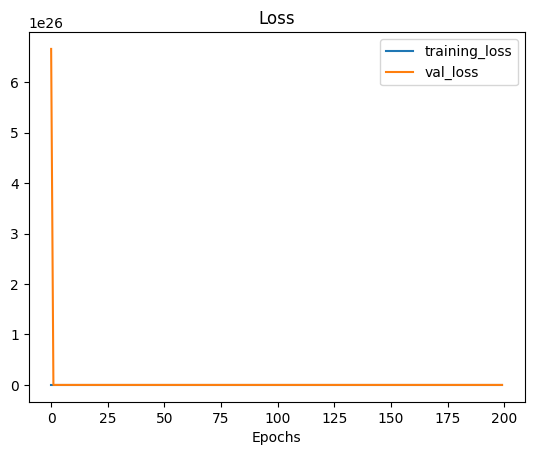

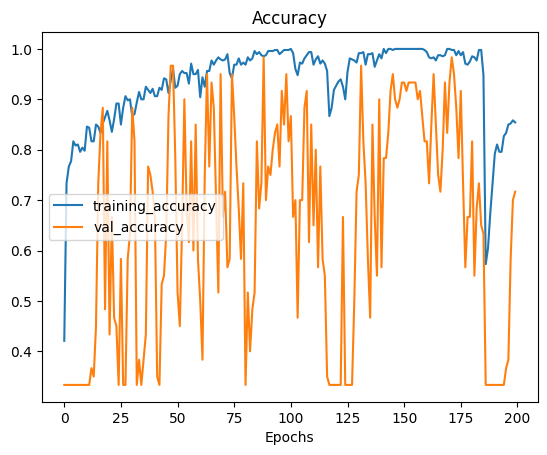

In [ ]:
plot_loss_curves(history_ResNet50_6)

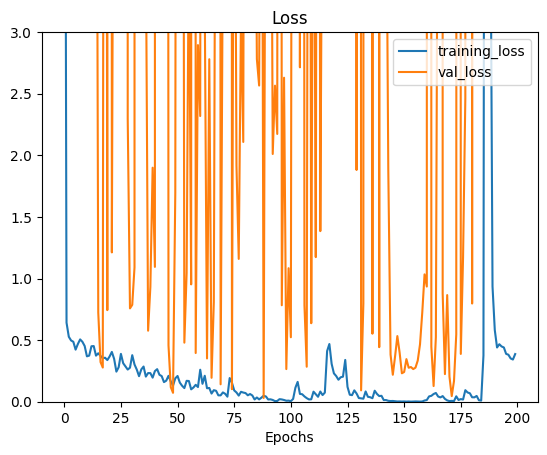

In [ ]:
plot_loss_curves_4(history_ResNet50_6)

## VGG16_7

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/200
8/8 [==============================] - 60s 4s/step - loss: 1.9130 - accuracy: 0.3604 - val_loss: 1.0936 - val_accuracy: 0.3667
Epoch 2/200
8/8 [==============================] - 9s 882ms/step - loss: 1.1073 - accuracy: 0.3521 - val_loss: 1.0890 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 8s 904ms/step - loss: 1.0983 - accuracy: 0.3500 - val_loss: 1.0824 - val_accuracy: 0.4167
Epoch 4/200
8/8 [==============================] - 8s 864ms/step - loss: 1.0880 - accuracy: 0.3583 - val_loss: 1.0678 - val_accuracy: 0.3667
Epoch 5/200
8/8 [==============================] - 8s 804ms/step - loss: 1.0615 - accuracy: 0.3500 - val_loss: 1.1818 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 8s 826ms/step - loss: 1.1260 - accuracy: 0.3250 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 7/200
8/8 [==============================] - 9s 790ms/step - loss: 1.0921 - accuracy:

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 578ms/step - loss: 0.7925 - accuracy: 0.9000
Loss : 0.792510986328125
Accuracy : 0.8999999761581421


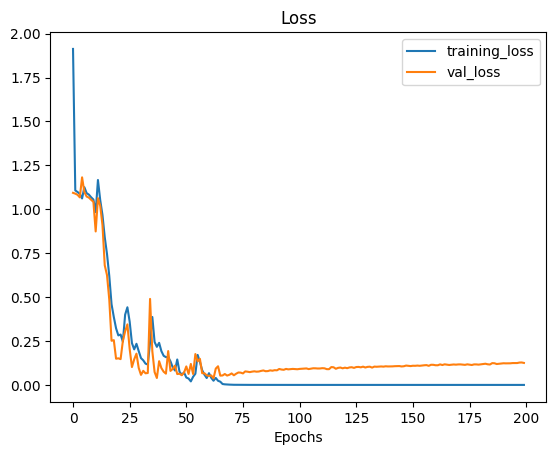

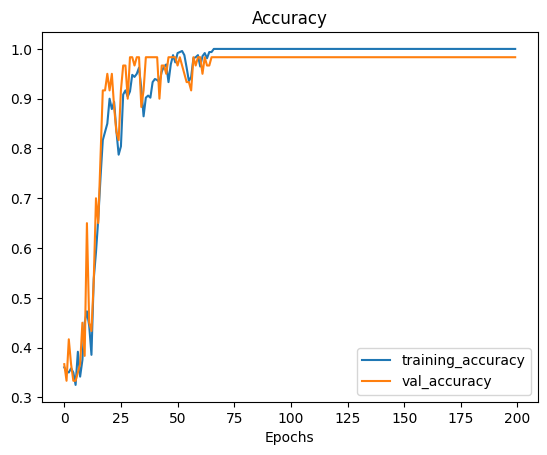

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_7)

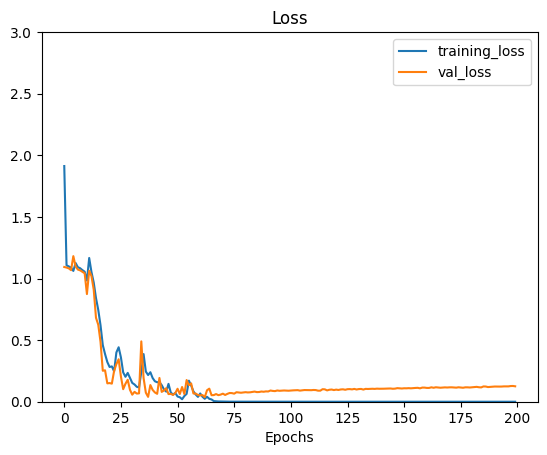

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves_4(history_VGG16_7)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_VGG16_7.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 5s 4s/step


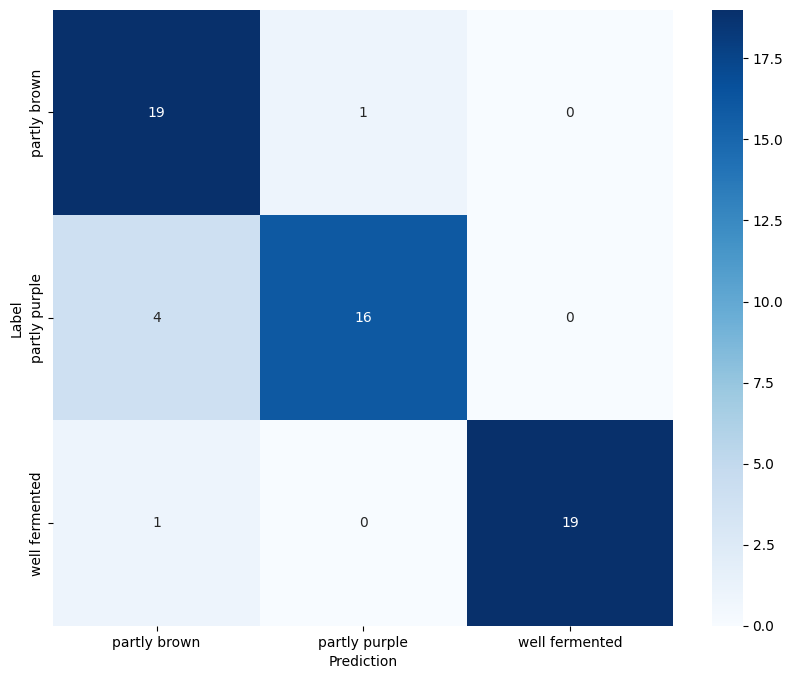

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

show_confusion_matrix(confusion_mtx, class_names)

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=True, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

ValueError: ignored

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_7)